#COMP 551 - Assignment 1

**Group Number:** 44<br><br>
**Members:**
  * **Ayaz Ciplak**<br>
  * **Jackie Silver**<br>
  * **Christopher Smith**<br><br>


### Task "0": Environment Configuration

**In this section, we will provide code for all necessary preconfigurations for this project. This includes:**
* Downloading dependencies
* Importing necessary libraries


**Downloading Dependencies**

In [46]:
!pip install ucimlrepo

**Imports**

In [47]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo, list_available_datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss

### Note: Remove unused imports at the end ###

### Task 1: Acquire, Preprocess, and Analyze the Data

**This section includes the following subsections:**
* Global variable initialization
* Loading datasets into Pandas DataFrames
* Visualizations and data preprocessing
* Statistics

**Global Variable Initialization**

These hold static values that have visibility throughout the program.

In [48]:
D1_ADDRESS="https://archive.ics.uci.edu/dataset/925/infrared+thermography+temperature+dataset"
D2_ADDRESS="https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators"

**Loading datasets into Pandas DataFrames**

In this subsection, we will process the dataset links, then use the ucimlrepo library to load in the data and convert it into Pandas DataFrames.

In [49]:
def extract_id(uci_datasetlink: str) -> int:
  """
  Extracts dataset ID from UCI Dataset link.
  Output can be passed into the fetch_ucirepo function to retrieve datasets from the repo
  """
  link_id = uci_datasetlink.split("/")[-2]
  return int(link_id)

# Extract dataset IDs from provided links
d1_id = extract_id(D1_ADDRESS)
d2_id = extract_id(D2_ADDRESS)

# Retrieve datasets
try:
  d1_dataset = fetch_ucirepo(id=d1_id)
  d2_dataset = fetch_ucirepo(id=d2_id)

except Exception as e:
  print("An error was encountered while attempting to load dataset with ID:", e)


# At this point, d1_dataset and d2_dataset hold the correct datasets from the UCI website
print("Initial dataset types:", type(d1_dataset), type(d2_dataset))

# We can now convert these to Pandas DataFrames, split between feature columns and target columns.
d1_features_df, d1_targets_df = d1_dataset.data.features, d1_dataset.data.targets
d2_features_df, d2_targets_df = d2_dataset.data.features, d2_dataset.data.targets

print("Casted dataset types:", type(d1_features_df), type(d1_targets_df), type(d2_features_df), type(d2_targets_df))


Initial dataset types: <class 'ucimlrepo.dotdict.dotdict'> <class 'ucimlrepo.dotdict.dotdict'>
Casted dataset types: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


#### **1.1 - Visualizations and data preprocessing of Dataset 1**

In this subsection, we will extract some preliminary information on dataset 1, and perform any necessary preprocessing. This will include:
* General info on the dataset
* Preprocessing:
  * Removing null values
  * Handling categorical features
  * Scaling features

In [50]:
# We can use the Pandas info() method to gain some basic insight on our dataset:
print("BASIC INFORMATION - DATASET 1 - FEATURES\n")
print(d1_features_df.info())
print("\n##############################################\n")
print("BASIC INFORMATION - DATASET 1 - TARGETS\n")
print(d1_targets_df.info())

BASIC INFORMATION - DATASET 1 - FEATURES

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gender       1020 non-null   object 
 1   Age          1020 non-null   object 
 2   Ethnicity    1020 non-null   object 
 3   T_atm        1020 non-null   float64
 4   Humidity     1020 non-null   float64
 5   Distance     1018 non-null   float64
 6   T_offset1    1020 non-null   float64
 7   Max1R13_1    1020 non-null   float64
 8   Max1L13_1    1020 non-null   float64
 9   aveAllR13_1  1020 non-null   float64
 10  aveAllL13_1  1020 non-null   float64
 11  T_RC1        1020 non-null   float64
 12  T_RC_Dry1    1020 non-null   float64
 13  T_RC_Wet1    1020 non-null   float64
 14  T_RC_Max1    1020 non-null   float64
 15  T_LC1        1020 non-null   float64
 16  T_LC_Dry1    1020 non-null   float64
 17  T_LC_Wet1    1020 non-null   float64
 18  T_LC_M

In [51]:
# Removing null values:
  # The d1_features dataframe visibly has null values:
print("Any null values in original DFs? [Features, Targets]:", d1_features_df.isnull().values.any(), d1_targets_df.isnull().values.any())
print("Amount of null values [Features, Targets]:", d1_features_df.isnull().sum().sum(), d1_targets_df.isnull().sum().sum())

  # These values visibly occur in the Distance column. To facilitate training the model, we will remove the rows containing null values in
  # the features table, and the corresponding ones in the targets table.
valid_rows = d1_features_df.dropna().index
cleaned_d1_features_df = d1_features_df.loc[valid_rows]
cleaned_d1_targets_df = d1_targets_df.loc[valid_rows]

  # We should now not have any null features remaining in our dataframes.
print("Any null values in processed DFs? [Features, Targets]:", cleaned_d1_features_df.isnull().values.any(), cleaned_d1_targets_df.isnull().values.any())


# Handling categorical values:
  # We have three categorical features - Gender, Ethnicity and Age.
    # Gender and Ethnicity are nominal categories -- There is no distinct relation between their subcategories. We use one-hot encoding to categorize them.
    # This will replace the current object-type columns with additional, boolean-value feature columns.
cleaned_d1_features_df = pd.get_dummies(cleaned_d1_features_df, columns=["Gender", "Ethnicity"], drop_first=True)

    # The Age category is ordinal - There is a distinct ordering between different subgroups (e.g. we can define a natural ordering by age range)
    # We can therefore use ordinal encoding to categorize them, reflecting their ordered nature.
print("Age categories (DF 1 - Features):", cleaned_d1_features_df["Age"].unique()) # First, we obtain a list of all observed age categories

    # Also note that there are overlapping categories -- Categories "21-25" and "26-30" also fit into the "21-30" category.
    # We can therefore convert all of these class instances into the more general "21-30" class.
cleaned_d1_features_df["Age"] = cleaned_d1_features_df["Age"].replace({'21-25': '21-30', '26-30': '21-30'})

    # There should now no longer be any overlapping age categories.
print("Cleaned age categories (DF 1 - Features):", cleaned_d1_features_df["Age"].unique())

    # We can provide an ordering for these values, and implement them as ordinal encodings in our dataframe
d1_features_age_ordering = ['18-20', '21-30', '31-40', '41-50', '51-60', '>60']
cleaned_d1_features_df["Age"] = pd.Categorical(
  cleaned_d1_features_df["Age"],
  categories=d1_features_age_ordering,
  ordered=True
)
cleaned_d1_features_df["Age"] = cleaned_d1_features_df["Age"].cat.codes # Assign integer codes based on value
cleaned_d1_features_df = cleaned_d1_features_df.rename(columns={"Age": "Age Category"}) # Assign more accurate name to "Age" column

    # To facilitate implementation, we can also convert all of our boolean valeus to 0/1 integer values
bool_d1_cols = cleaned_d1_features_df.select_dtypes(include=['bool']).columns
cleaned_d1_features_df[bool_d1_cols] = cleaned_d1_features_df[bool_d1_cols].astype(int) # Cast to int-type values

    # To improve model speed, we also downcast our feature column types to the smallest unit possible without affecting the data.
for col in cleaned_d1_features_df.columns:
  if pd.api.types.is_integer_dtype(cleaned_d1_features_df[col]):
  # Downcast integers to the smallest possible integer type
    cleaned_d1_features_df[col] = pd.to_numeric(cleaned_d1_features_df[col], downcast='integer')
  elif pd.api.types.is_float_dtype(cleaned_d1_features_df[col]):
    # Downcast floats to the smallest possible float type
    cleaned_d1_features_df[col] = pd.to_numeric(cleaned_d1_features_df[col], downcast='float')

# Scaling features
  # Since we are using analyitcal linear regression (i.e. using a closed-form solution), scaling is not required to get an accurate solution

# We now have our cleaned features and targets datasets:
print(cleaned_d1_features_df.info())
print("\n##############################################\n")
print(cleaned_d1_targets_df.info())

Any null values in original DFs? [Features, Targets]: True False
Amount of null values [Features, Targets]: 2 0
Any null values in processed DFs? [Features, Targets]: False False
Age categories (DF 1 - Features): ['41-50' '31-40' '21-30' '18-20' '26-30' '21-25' '>60' '51-60']
Cleaned age categories (DF 1 - Features): ['41-50' '31-40' '21-30' '18-20' '>60' '51-60']
<class 'pandas.core.frame.DataFrame'>
Index: 1018 entries, 0 to 1019
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age Category                         1018 non-null   int8   
 1   T_atm                                1018 non-null   float32
 2   Humidity                             1018 non-null   float32
 3   Distance                             1018 non-null   float32
 4   T_offset1                            1018 non-null   float32
 5   Max1R13_1                            1018 non-null   float32
 6 

**Statistics - Dataset 1**


In this subsection, we will compute some basic statistics on our data to better understand it.

count    1018.000000
mean       37.028163
std         0.509743
min        35.540000
25%        36.752500
50%        36.940000
75%        37.140000
max        40.340000
Name: aveOralM, dtype: float64


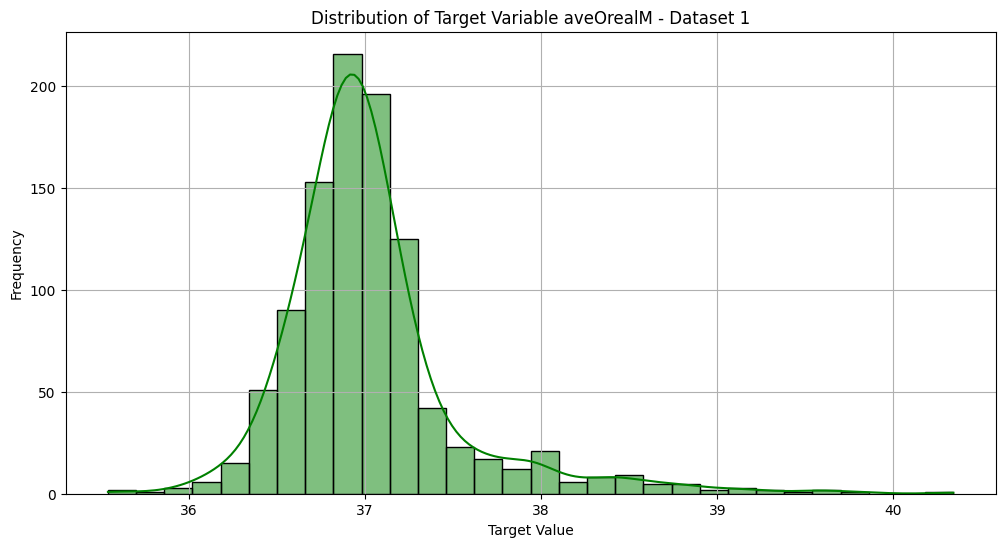

In [52]:
### TARGETS ###
# Since our target value (aveOralM) is continuous, we cannot necessarily determine positive vs. negative classes.
# However, we can visualize the distribution of the values.

print(cleaned_d1_targets_df["aveOralM"].describe()) # Prints general stats on the dataset

# We can also plot the distribution of our target values
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_d1_targets_df['aveOralM'], bins=30, kde=True, color='green')
plt.title('Distribution of Target Variable aveOrealM - Dataset 1')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Observations:
# (Finish observations)

In [53]:
### FEATURES - NUMERICAL ###

# Visualizing numerical features

print('Box Plots of Distribution for Numerical Features - Dataset 1\n')

  # Using matplotlib, we can show individual feature distributions
d1_numerical_cols = cleaned_d1_features_df.select_dtypes(include=['float64']).columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(d1_numerical_cols, 1):
    plt.subplot(5, 6, i)  # Adjust the number of rows and columns as needed
    sns.histplot(cleaned_d1_features_df[col], bins=30, kde=True, color="green")
    plt.title(col)
plt.tight_layout()
plt.show()

# Observations:
# Most numerical values follow a relatively normal distribution, with the exception of Humidity and Distance.

Box Plots of Distribution for Numerical Features - Dataset 1



<Figure size 1200x800 with 0 Axes>

Box Plots of Distribution for Categorical Features - Dataset 1



<ipython-input-54-20d122832806>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1_features_df["Age"] = d1_features_df["Age"].replace({'21-25': '21-30', '26-30': '21-30'})


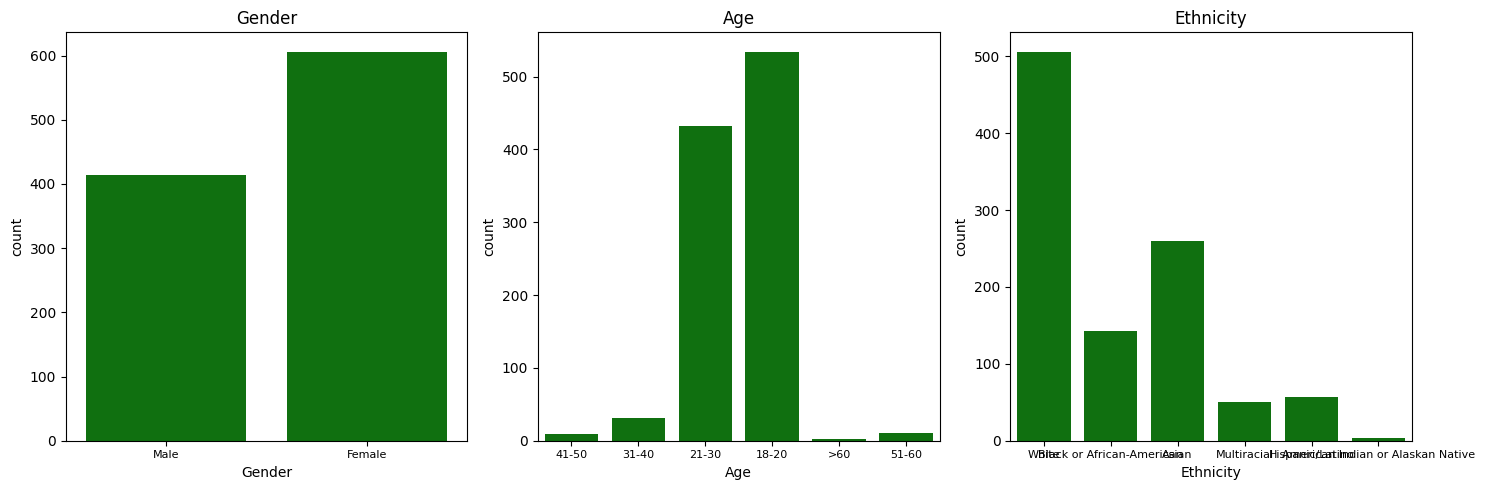

In [54]:
### FEATURES - CATEGORICAL ###

  # We can also visualize categorical features like Age, Gender and Ethnicity.
  # Note that we are using the original dataset for this to display the distribution of unprocessed features.
print('Box Plots of Distribution for Categorical Features - Dataset 1\n')

  # For ease of understanding, the overlapping age categories will also be combined here.
d1_features_df["Age"] = d1_features_df["Age"].replace({'21-25': '21-30', '26-30': '21-30'})

d1_categorical_cols = d1_features_df.select_dtypes(include=['object']).columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(d1_categorical_cols, 1):
    plt.subplot(1, 3, i)  # Adjust as needed
    sns.countplot(data=d1_features_df, x=col, color="green")
    plt.title(col)
    plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()

# Observations:
# Notice that most categorical values have a slightly uneven distribution:
  # In the Gender category, there are more data points for female patients.
  # For the Age category, we can see that most patients are younger, wtih the large majority falling in the "18-20" and "21-25" categories.
  # For the Ethnicity category, we can see that a large proportion of the patients were White or Asian.

#### **1.2 - Visualizations and data preprocessing of Dataset 2**

In this subsection, we will extract some preliminary information on dataset 2, and perform any necessary preprocessing. This will include:
* General info on the dataset
* Preprocessing:
  * Removing null values
  * Handling categorical features
  * Scaling features

In [55]:
# We can use the Pandas info() method to gain some basic insight on our dataset:

print("\nBASIC INFORMATION - DATASET 2 - FEATURES\n")
print(d2_features_df.info())
print("\n##############################################\n")
print("BASIC INFORMATION - DATASET 2 - TARGETS\n")
print(d2_targets_df.info())
print("\n##############################################")
print("##############################################")


BASIC INFORMATION - DATASET 2 - FEATURES

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  in

In [56]:
# Removing null values:
  # The d2_features and d2_targets dataframes do not have any null values, so no removal is necessary:
print("Any null values in original DFs? [Features, Targets]:", d2_features_df.isnull().values.any(), d2_targets_df.isnull().values.any())


# Handling categorical values:
  # We do not have any categorical values in this dataset! There are some boolean values encoded as 0/1 integers, but this can be left as is.

# Scaling features
  # Scaling can improve convergence speed while using gradient descent. We can therefore standardize our features to have zero mean and unit variance.

d2_scaler = StandardScaler()
scaled_d2_features = d2_scaler.fit_transform(d2_features_df)

# Return back to dataframe, and downcast from float64 to float32
  # Downcasting can improve the compute time and memory usage as a smaller datatype means less memory usage
cleaned_d2_features_df = pd.DataFrame(scaled_d2_features, columns=d2_features_df.columns).astype('float32')
cleaned_d2_targets_df = d2_targets_df.astype('int8') # No changes were made to the targets df

# We now have our cleaned features and targets datasets:
print(cleaned_d2_features_df.info())
print("\n##############################################\n")
print(cleaned_d2_targets_df.info())

Any null values in original DFs? [Features, Targets]: False False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                253680 non-null  float32
 1   HighChol              253680 non-null  float32
 2   CholCheck             253680 non-null  float32
 3   BMI                   253680 non-null  float32
 4   Smoker                253680 non-null  float32
 5   Stroke                253680 non-null  float32
 6   HeartDiseaseorAttack  253680 non-null  float32
 7   PhysActivity          253680 non-null  float32
 8   Fruits                253680 non-null  float32
 9   Veggies               253680 non-null  float32
 10  HvyAlcoholConsump     253680 non-null  float32
 11  AnyHealthcare         253680 non-null  float32
 12  NoDocbcCost           253680 non-null  float32
 13  GenHlth               253680 non-null 

**Statistics - Dataset 2**


In this subsection, we will compute some basic statistics on our data to better understand it.

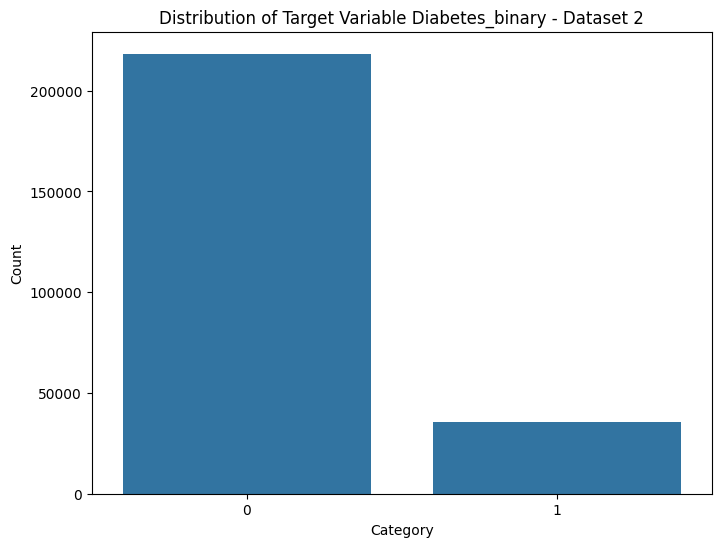

In [57]:
### TARGETS ###
# Our target value (diabetes_binary) is categorical.
plt.figure(figsize=(8, 6))
sns.countplot(x='Diabetes_binary', data=d2_targets_df)
plt.title('Distribution of Target Variable Diabetes_binary - Dataset 2')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Observations:
# We can see that there are a much higher amount of negative (0) data points for diabetes than positive ones.
# Since we have so few positive entries for diabetes, our target dataset is relatively imbalanced.

Categorical columns - Dataframe 2: Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex',
       'Age', 'GenHlth', 'MentHlth', 'PhysHlth', 'Education', 'Income'],
      dtype='object')
Numerical columns - Dataframe 2: Index(['BMI'], dtype='object')

Box Plot of Distribution for Numerical Feature - Dataset 2



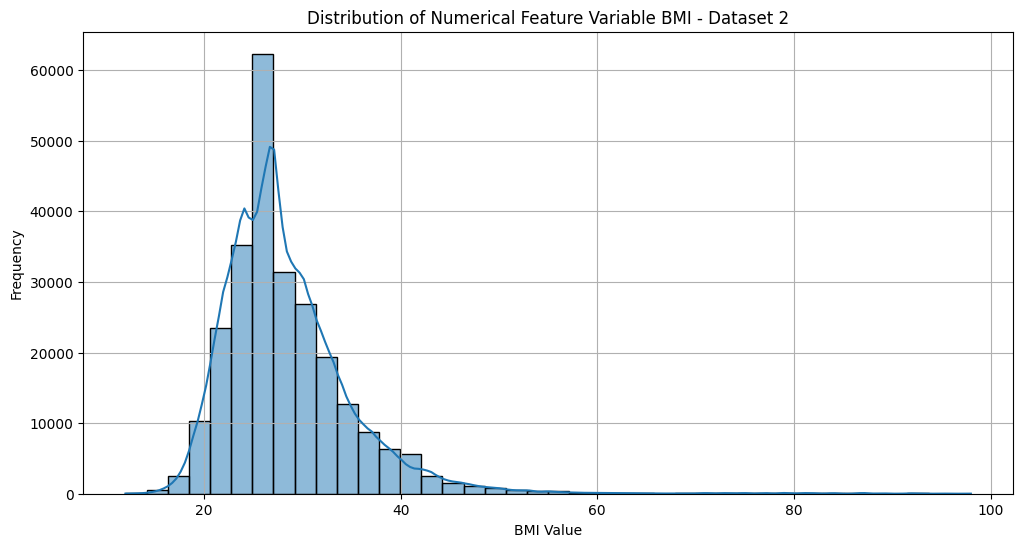

In [58]:
### FEATURES - NUMERICAL ###

# Although all features in our dataset 2 are encoded as float64 entries, some are intuitively numerical
# whereas others are categorical (i.e. boolean values encoded as 0/1 entries)
# We can start by noting that all features that strictly have 0/1 values are boolean categorical entries:
d2_categorical_cols = pd.Index([ # Filter by columns that only strictly contain 0-1 values
    col for col in d2_features_df
    if set(d2_features_df[col].unique()).issubset({0, 1})
])

# Although some other categories may seem numerical, many are actually better classified as ordinal categorical. For example,
  # As per the dataset website, the "age" value represents a 13-level age category rather than an actual age, and is therefore ordinal categorical
d2_categorical_cols = d2_categorical_cols.append(pd.Index(["Age"]))
  # Similarly, the Income, Education, GenHlth, MentHlth, and PhysHlth features represent classifications rather than concrete values.
  # They are therefore also best considred as ordinal categorical features.
d2_categorical_cols = d2_categorical_cols.append(pd.Index(["GenHlth", "MentHlth", "PhysHlth", "Education", "Income"]))

# We can define the numerical columns in our feature dataset as the set of all columns that are not categorical.
d2_numerical_cols = d2_features_df.columns.difference(d2_categorical_cols)

print("Categorical columns - Dataframe 2:", d2_categorical_cols)
print("Numerical columns - Dataframe 2:", d2_numerical_cols)

# Observe that only one column in our features dataframe (2) is considered numerical -- BMI
  # Using matplotlib, we can show the distribution of this feature

print('\nBox Plot of Distribution for Numerical Feature - Dataset 2\n')

plt.figure(figsize=(12, 6))
sns.histplot(d2_features_df['BMI'], bins=40, kde=True)
plt.title('Distribution of Numerical Feature Variable BMI - Dataset 2')
plt.xlabel('BMI Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Observations:
# The BMI's distribution is right-skewed, with some very large outliers on the right.

Categorical columns - Dataframe 2: Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex',
       'Age', 'GenHlth', 'MentHlth', 'PhysHlth', 'Education', 'Income'],
      dtype='object')


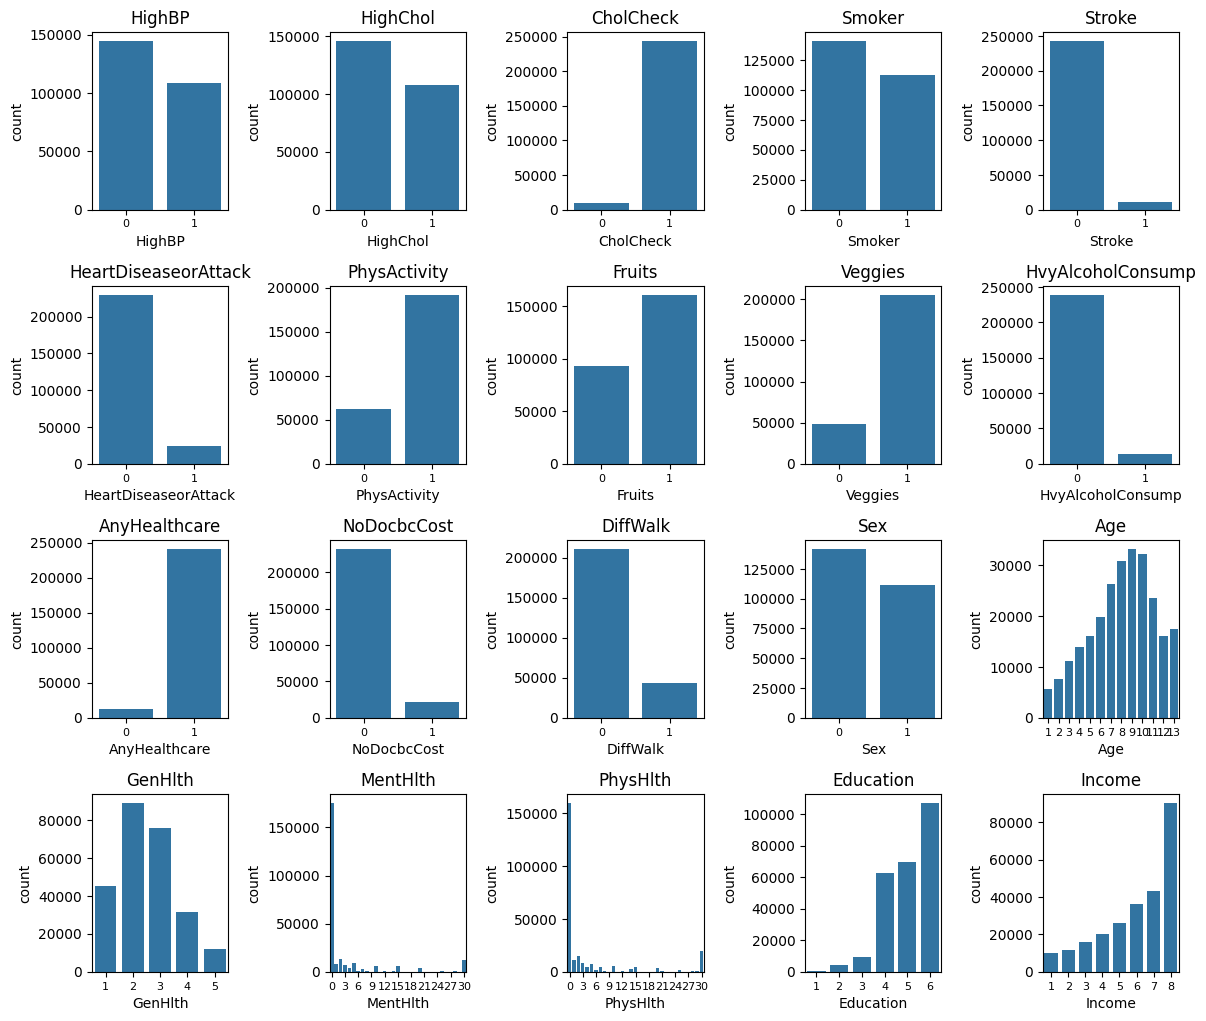

In [59]:
### FEATURES - CATEGORICAL ###

# Although all features in our dataset 2 are encoded as float64 entries, some are intuitively numerical
# whereas others are categorical (i.e. boolean values encoded as 0/1 entries)

# We have determined our categorical features in the last code block
print("Categorical columns - Dataframe 2:", d2_categorical_cols)

plt.figure(figsize=(12, 15))
for i, col in enumerate(d2_categorical_cols, 1):
  plt.subplot(6, 5, i)  # Adjust as needed
  sns.countplot(data=d2_features_df, x=col)
  plt.title(col)

  # Sparser x-axis labels for features with more categories
  num_labels = d2_features_df[col].nunique()
  if num_labels > 10:
    plt.xticks(ticks=range(0, num_labels, max(1, num_labels // 10)), fontsize=8)
  else:
    plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()


# Observations:
#

### Task 2: Implement the Models

**This section includes the following subsections:**
* Implement analytical linear regression solution (Dataset 1)
* Implement logistic regression with gradient descent (Dataset 2)
* Implement mini-batch stochastic gradient descent, for both linear and logistic regression

#### **2.1 - Linear Analytical Regression (Dataset 1)**

In this subsection, we will define a LinearRegression class that can be trained according to our feature data (and other parameters), as well as make predictions based on the learned weights.
* Since we are implementing linear analytical regression, our class will use matrix operations to solve the closed-form solution for optimal weights.


The objective of **linear regression** is to find a set of weights that most accurately predict target values according to the set of features.

In [60]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        self.w = np.linalg.inv(x.T @ x)@x.T@y      # use analytical matrix multiplication solution
        return self

    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


When more than one feature is being considered, the following formula represents the Linear Regression:


fw(x) = $w_0$ + $w_1$$x_1$ + $w_2$$x_2$ ... + $w_D$$x_D$

$w_0$, $w_1$,..., $w_D$ being the model parameters/weights, with $w_0$ being the bias / intercept

_As an example, we can train our model with the entirety of the feature and target data, to get a sense of the weights that will be assigned to each feature._

In [61]:
# Extract relevant values from dataframes
x = cleaned_d1_features_df.values
y = cleaned_d1_targets_df["aveOralM"].values

# Initialize model
lin_model = LinearRegression(add_bias=True)
lin_model.fit(x, y)

# Extract and display the predicted weights
d1_test_feature_weights = lin_model.w
print("Weights (including bias):", d1_test_feature_weights)

# To test out our accuracy, we can compare the model predictions and the actual target values

  # 1. Predict our outputs based on our calculated weight set
d1_test_y_pred = lin_model.predict(x)

print("\nFirst 10 predictions for aveOralM:", d1_test_y_pred[:10])
print("\nFirst 10 actual values for aveOralM:", d1_targets_df['aveOralM'].head(10))



Weights (including bias): [ 9.25736260e-03 -6.69703895e-02  8.80313651e-05  2.43755183e-03
  5.93912149e-02 -3.61397454e-01 -1.37990532e-01 -3.39286299e-02
 -5.43956009e-02 -1.68377788e-01  2.53053356e-01  5.84073078e-02
  3.67971409e-01  1.39685758e+00 -1.71098446e-01 -1.31945377e-01
 -9.61282431e-01  6.50556901e-02  1.45358925e-01 -3.34598815e-01
  2.46696606e-01 -9.77943863e-02 -2.15991809e-02 -9.94881528e-02
  9.03038194e-02  5.81856559e-03  1.09052530e-01  1.00591336e-01
  5.65387008e-01  2.83025471e-01 -1.61199023e-01 -3.96563692e-02
  1.06820989e-03  4.41055896e-02 -4.14039938e-02 -5.51001870e-02
 -5.42691149e-02  4.39302604e+00]

First 10 predictions for aveOralM: [36.5464796  36.3909484  36.95440486 36.77690516 36.84529928 36.73495557
 36.80703064 36.37974653 36.81860753 36.91557561]

First 10 actual values for aveOralM: 0    36.59
1    37.19
2    37.34
3    37.09
4    37.04
5    36.99
6    36.59
7    36.49
8    36.59
9    36.89
Name: aveOralM, dtype: float64


#### **2.2 - Logistic Regression with Gradient Descent (Dataset 2)**

In this subsection, we will define a LogisticRegression class that can be trained according to our feature data (and other parameters), as well as make predictions based on the learned weights.

* We will be using gradient descent to iteratively optimize our cost function and find the optimal weight set.

* In this subsection, we will have the following sections:
  1. Defining the logistic/sigmoid function and plotting it
  2. Defining and analysing a cost function
  3. Creating a gradient function
  4. Initializing a LogisticRegression class

**1. Defining the logistic/sigmoid function and plotting it.**

In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.

Text(0.5, 1.0, 'Logistic Function Plot')

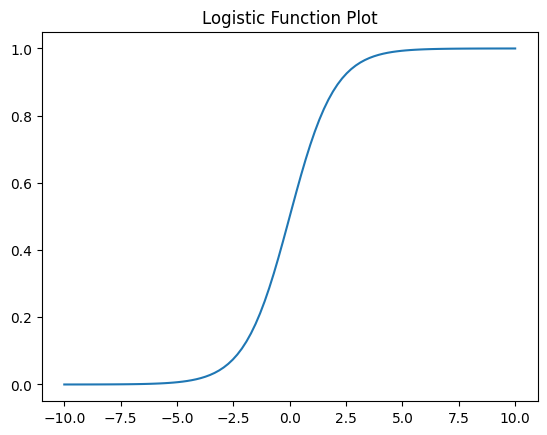

In [62]:
# We will first define the logistic/sigmoid function, used to map real-valued numbers into the range (0, 1).

def logistic(z):
  return (1./ (1 + np.exp(-z)))

# We can also visualize this function, as per the code in class:
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('Logistic Function Plot')

# Recap - Mathmatical operations involved in logistic regression

# x [N, D]      Represents the input data matrix, where N is the number of samples and D is the number of features
# w [D]         Represents the weights vector, an array of size D (num. of features)
# x@w [N]       Represents the dot product of the input data and weights, resulting in a 1D array of size N
# logistic(x@w) [N]     After applying the logistic function to this dot product, we generate a probability for each sample.

**2. Defining and analyzing a cost function**

To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.


In [63]:
def cost_fn(x, y, w):
  """
  Inputs:
  - x: The input feature matrix (N is the number of samples, D is the number of features)
  - y: The target feaure matrix (Containing the actual, binary, 0/1 values for each sample)
  - w: A weight vector.

  Output:
  - Total cost given a certain value of <w>
  """
  N, D = x.shape
  z = np.dot(x, w)
  J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies
  # prev. line uses cross-entropy loss
  return J

**3. Creating a gradient function**

To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)})
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

In [64]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

**4. Initializing a LogisticRegression class**

Below, we implement a Logistic Regression class, with fit and predict methods. This class uses the gradient function we defined above.

In [65]:
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            t += 1

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self, x, threshold=0.5):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])

        yh = logistic(np.dot(x,self.w))            #predict output
        y_pred = (yh >= threshold).astype(int)     #convert probas to binary

        return y_pred

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

#### **2.3 - Mini-batch Stochastic Gradient Descent**

In this subsection, we will be implementing a mini-batch Stochastic Gradient Descent (SGD) for both the linear and logistic regression models. This will serve as an alternative optimizer to minimize the cost function for each model. We will write each cost function as an average over each batch of instances:

$$
\nabla J(w) = \mathbb{E}[\nabla J_B(w)] = \frac{1}{|B|} \sum_{n \in B} \nabla J_n(w)
$$

**Defining our Mini-Batch SGD class:**


In [66]:
class StochasticGradientDescent:
    def __init__(self, lr=0.001, max_iters=1e4, epsilon=1e-4, batch_size=16, record_history=False, verbose=False):
        self.lr = lr                                    #learning rate
        self.max_iters = max_iters                      #maximum iterations
        self.epsilon = epsilon                          #convergence threshold
        self.batch_size = batch_size                    #batch size
        self.verbose = verbose                          #flag to print logs

        self.record_history = record_history            #flag to store weight history for visualization
        if record_history:
            self.history = []                           #store weight history


    def run(self, gradient_fn, x, y, w):
      N = x.shape[0]
      grad_norm = np.inf
      t = 1

      while grad_norm > self.epsilon and t < self.max_iters:
        # Shuffle the data at the start of each epoch (ie every full batch of data)
        indices = np.arange(N)
        np.random.shuffle(indices)
        x_shuffled = x[indices]
        y_shuffled = y[indices]

        # Iterate through mini-batches
        for start_idx in range(0, N, self.batch_size):
          end_idx = min(start_idx + self.batch_size, N)   #take min of batch size or remaining samples
          x_batch = x_shuffled[start_idx:end_idx]
          y_batch = y_shuffled[start_idx:end_idx]

          #compute gradient of batch
          grad = gradient_fn(x_batch, y_batch, w)


          #cur batch weight update
          w = w - self.lr * grad

          if self.record_history:
              self.history.append(w)

          #further stopping within current epoch
          grad_norm = np.linalg.norm(grad)                 #check grad norm for convergence
          if grad_norm < self.epsilon:
            break

        #one iteration done
        t += 1

      #Results
      if self.verbose:
        print(f"Final weights are: {w}. Terminated after {t} iterations.")

      return w


**1. For Linear Regression**

In the previous subsection, we defined a **LinearRegression class** where we modeled our targets as a linear function of features, and optimized our parameters by minimizing the mean squared error using the closed-form solution (i.e. using matrix inversion).<br><br>


In this section, we will be using the mini-batch gradient descent  method, which involves iteratively adjusting the model's paramenters by computing the gradient of the loss function for each "mini batch", or a small portion, of the dataset. To do this, we will extend the LinearRegression class into a new **LinearRegressionSGD**:

In [67]:
class LinearRegressionSGD(LinearRegression):
    def __init__(self, add_bias=True, lr=0.001, max_iters=1e4, epsilon=1e-8, batch_size=16, record_history=False, verbose=False):
      super().__init__(add_bias=add_bias)
      self.optimizer = StochasticGradientDescent(lr, max_iters=max_iters, epsilon=epsilon, batch_size=batch_size, record_history=record_history, verbose=verbose)


    def fit(self, x, y):
      if x.ndim == 1:
          x = x[:, None]

      if self.add_bias:                                        #add bias to features
          N = x.shape[0]
          x = np.column_stack([x,np.ones(N)])

      N,D = x.shape                                            #num of samples, num of features
      w0 = np.zeros(D)                                         #init weights to 0

      # define the gradient function
      def gradient_lin(x, y, w):
          yh =  x @ w
          N, D = x.shape
          grad = .5*np.dot(yh - y, x)/N
          return grad

      #Run mini-batch SGD
      self.w = self.optimizer.run(gradient_lin, x, y, w0)      # run the optimizer to get the optimal weights
      return self



**2. For Logistic Regression**

Similarly, the **LogisticRegression** class is extended to use mini-batch SGD for optimization. For logistic regression, we optimize the cross-entropy loss by iteratively computing the gradient of each batch. Here we define the extended **LogisticRegressionSGD** class:


In [68]:
class LogisticRegressionSGD(LogisticRegression):
    def __init__(self, add_bias=True, lr=0.01, max_iters=1e4, epsilon=1e-4, batch_size=16, record_history=False, verbose=False):
      super().__init__(add_bias=add_bias, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=verbose)
      self.optimizer = StochasticGradientDescent(lr, max_iters=max_iters, epsilon=epsilon, batch_size=batch_size, record_history=record_history)


    def fit(self, x, y):
      if x.ndim == 1:
        x = x[:, None]

      if self.add_bias:
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])

      N,D = x.shape                           #num of samples, num of features
      w0 = np.zeros(D)                        #init weights to 0

      def gradient_log(x, y, w):
        #same grad fct as before
        N,D = x.shape
        yh = logistic(np.dot(x, w))      #predictions  size N
        grad = np.dot(x.T, yh - y) / N        #divide by N cost is mean over size of batch
        return grad                           #size D

      #Run mini-batch SGD
      self.w = self.optimizer.run(gradient_log, x, y, w0)

      return self

### Task 3: Run Experiments

In this section, we will conduct a series of experiments on two datasets to evaluate and compare the performance of different models. For each dataset, we will explore the following topics:

* Model performance
* Weights analysis
* Training data size analysis
* Minibatch size variation analysis
* Performance with variation of learning rates analysis
* Analytical vs. mini-batch comparison
* Additional Topics

#### **Dataset 1**
In this subsection, we will report the performance of the linear regression model on dataset 1. We will start out with a 80-20 train-test split, and report the performance on both the training set and test set. From there, we will compare the performance of the model using the analytical solution to the mini-batch Stochastic Gradient Descent (SGD) solution, and examine the effects in performance by varying the size of the training data, the batch size and the learning rate for the SGD solution.<br><br>

First we must prepare the data:


In [69]:
# To avoid any bias in our train-test set split, we will first shuffle our data

  # 1. Combine the features and targets
total_cleaned_d1_data = pd.concat([cleaned_d1_features_df, cleaned_d1_targets_df], axis=1)

  # 2. Shuffle the dataframe
shuffled_total_d1_data = total_cleaned_d1_data.sample(frac=1, random_state=42).reset_index(drop=True)
d1_split_index = int(0.8 * len(shuffled_total_d1_data))

  # 3. Split the data into train and test datasets
train_d1_data = shuffled_total_d1_data[:d1_split_index]
test_d1_data = shuffled_total_d1_data[d1_split_index:]

  # 4. Separate features and targets
x_train_d1 = train_d1_data[cleaned_d1_features_df.columns].values
y_train_d1 = train_d1_data["aveOralM"].values
x_test_d1 = test_d1_data[cleaned_d1_features_df.columns].values
y_test_d1 = test_d1_data["aveOralM"].values


# We can now initialize and train the model.
linear_model = LinearRegression(add_bias=True)
linear_model.fit(x_train_d1, y_train_d1)

d1_feature_weights = linear_model.w

y_pred = linear_model.predict(x_test_d1) # Predictions on the test set
y_pred_train = linear_model.predict(x_train_d1) # Predictions on the training set


##### **1.1 - Model Performance**

We will measure the performance of our analytical model based on four metrics.
* **MAE (Mean Absolute Error):** The average of the absolute differences between the predicted and actual values. This measure robust to outliers, and is commonly used when you want an easily interpretable error metric.

* **MSE (Mean Squared Error):** The average of squared differences between the predicted and actual values. Outliers may have a large impact, and it is commonly used when large errors are particularly undesirable.

* **MAPE (Mean Absolute Percentage Error):** The average of the absolute percentage differences between the predicted and actual values. It expresses the error as a percentage of the actual values, making it scale-independent. This measure may lead to large errors when actual values are close to zero, and is best used when you need to understand the error in percentage terms.

* **R-Squared Value:** Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. It provides insight on how well the regression model fits the observed data.

In [70]:
# Now, we can measure performance according to popular performance metrics

# Measuring performance on training set
print("\nPerformance measures on the training set - Dataset 1 - Analytical Linear Regression: ")
d1_mae_train = np.mean(np.abs(y_train_d1 - y_pred_train))
print(f"Mean Absolute Error (Train): {d1_mae_train:.2f}")

d1_mse_train = np.mean((y_train_d1 - y_pred_train) ** 2)
print(f"Mean Squared Error (Train): {d1_mse_train:.2f}")

d1_rmse_train = np.sqrt(d1_mse_train)
print(f"Root Mean Squared Error (Train): {d1_rmse_train:.2f}")

d1_ss_res_train = np.sum((y_train_d1 - y_pred_train) ** 2)
d1_ss_tot_train = np.sum((y_train_d1 - np.mean(y_train_d1)) ** 2)
d1_r_squared_train = 1 - (d1_ss_res_train / d1_ss_tot_train)
print(f"R-squared (Train): {d1_r_squared_train:.2f}")


# Measuring performance on test set
print("\nPerformance measures on test set - Dataset 1 - Analytical Linear Regression: ")
d1_mae = np.mean(np.abs(y_test_d1 - y_pred))
print(f"Mean Absolute Error (Test): {d1_mae:.2f}")

d1_mse = np.mean((y_test_d1 - y_pred) ** 2)
print(f"Mean Squared Error (Test): {d1_mse:.2f}")

d1_rmse = np.sqrt(d1_mse)
print(f"Root Mean Squared Error (Test): {d1_rmse:.2f}")

d1_ss_res = np.sum((y_test_d1 - y_pred) ** 2)
d1_ss_tot = np.sum((y_test_d1 - np.mean(y_test_d1)) ** 2)
d1_r_squared = 1 - (d1_ss_res / d1_ss_tot)
print(f"R-squared (Test): {d1_r_squared:.2f}")



Performance measures on the training set - Dataset 1 - Analytical Linear Regression: 
Mean Absolute Error (Train): 0.19
Mean Squared Error (Train): 0.06
Root Mean Squared Error (Train): 0.24
R-squared (Train): 0.78

Performance measures on test set - Dataset 1 - Analytical Linear Regression: 
Mean Absolute Error (Test): 0.21
Mean Squared Error (Test): 0.07
Root Mean Squared Error (Test): 0.27
R-squared (Test): 0.63


**Performance Analysis**<br>

According to our computed weights, the linear regression model performs moderately well on both the training set and the test set.

Training set:
* We achieve reasonably good values for MAE, MSE and RMSE. Our R-squared value is also good -- It indicates that our model explains 78% of the variance in the training set.

Test set:
* All measures (MAE, MSE, RMSE, R^2) perform fine on the test set, but are still uniformly worse than the measures for the training set.
* Since we have not implemented any sort of regularization or other prevention against overfitting, this makes sense - The model is designed to fit most optimally towards the information it has seen (training set)

##### **1.2 - Weights Analysis**
In this subsection, we will report the weights of each of the features in our trained models and discuss how each feature could affect the
performance of the models.


Dataset 1 - Analytical Linear Regression Weights (including bias):
                                 Feature    Weight
37                                 Bias  4.316695
12                            T_RC_Max1  1.367014
13                                T_LC1  1.151504
20                          canthi4Max1  0.527438
28                               T_Max1  0.526659
10                            T_RC_Dry1  0.351641
30                            T_OR_Max1  0.171605
18                                 LCC1  0.112620
26                            T_FH_Max1  0.106186
11                            T_RC_Wet1  0.093410
27                           T_FHC_Max1  0.092713
24                              T_FHBC1  0.079018
4                             T_offset1  0.054588
17                                 RCC1  0.047558
14                            T_LC_Dry1  0.039089
7                           aveAllR13_1  0.014458
0                          Age Category  0.014027
3                              D

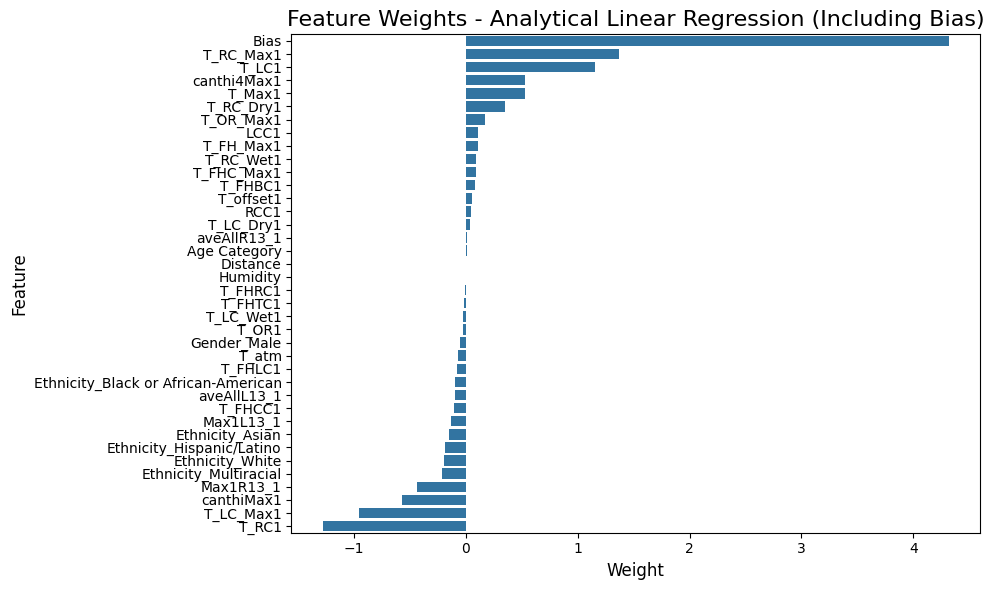

In [71]:
# Reassociate the weights from when we ran the model to the cleaned feature names:

feature_names = cleaned_d1_features_df.columns.tolist()  #get feature names
feature_names_w_bias = feature_names + ["Bias"] #add the bias as a feature

d1_feature_weights_df = pd.DataFrame({
    'Feature': feature_names_w_bias,
    'Weight': d1_feature_weights
})

d1_feature_weights_df = d1_feature_weights_df.sort_values(by='Weight', ascending=False)

print("Dataset 1 - Analytical Linear Regression Weights (including bias):\n", d1_feature_weights_df)

# Plotting the weights as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=d1_feature_weights_df)

# Adding title and labels
plt.title("Feature Weights - Analytical Linear Regression (Including Bias)", fontsize=16)
plt.xlabel("Weight", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

**Analysis**

High-influence weights:
* Factors like T_RC_Max1, T_LC1, T_LC_Max1 and T_RC1 have relatively high absolute weight values.
* This indicates that they have more effect/influence on the value of our target column AveOralM.
* Columns with higher (positive) non-absolute values indicate that an increase in the feature values lead to an increase in the target value.
* Columns with lower (negative) non-absolute values indicate the opposite - An increase in the feature value leads to a a decrease in the target value.

Low-influence weights:
* Features like Humidity and Distance have almost negligible weight values.
* This indicates that they contribute very little to the prediction. The feature values may be irrelevant or redundant to the behaviour of our target value AveOralM.

##### **1.3 - Effects of Variation in Size of Training Data**
In this subsection, we will sample growing subsets of the training data (20%,30%,...80%). We will observe and explain how the size of training
data affects the performance for our linear regression model. We will plot two curves as a function of training size, one for performance in train and one for test.


[0.04448789728079825, 0.04974299397777569, 0.04877698140656831, 0.05269361143765382, 0.053674228729913454, 0.05479589694215402, 0.060014418204594036]
[0.2229176100388319, 0.07526271879351523, 0.07739473337734397, 0.07664381129769705, 0.08018886455287268, 0.08381569905523996, 0.07324051019696783]


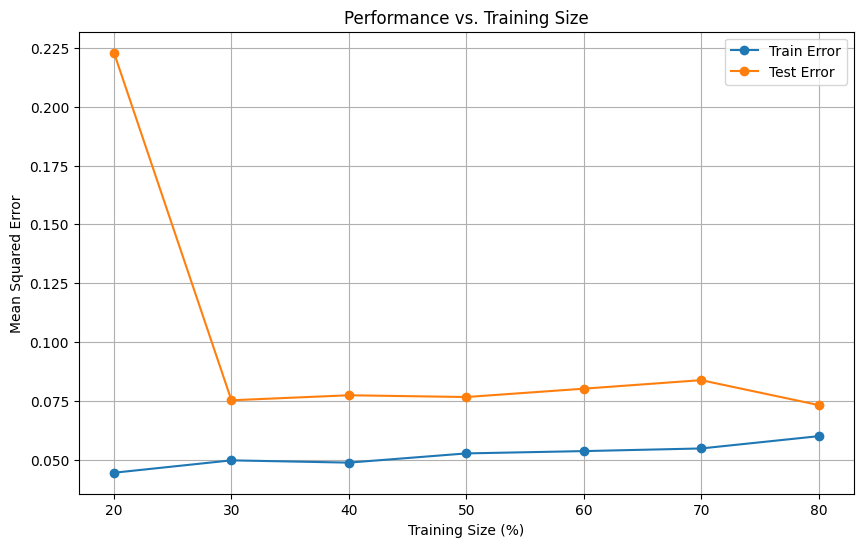

In [72]:
percentages = np.arange(0.2, 0.9, 0.1)
d1_train_errors, d1_test_errors = [], []

for percentage in percentages:
  sub_index = int(percentage * len(shuffled_total_d1_data))
  train_subset = shuffled_total_d1_data[:sub_index]
  test_subset = shuffled_total_d1_data[sub_index:]

  x_train = train_subset[cleaned_d1_features_df.columns].values
  y_train = train_subset["aveOralM"].values
  x_test = test_subset[cleaned_d1_features_df.columns].values
  y_test = test_subset["aveOralM"].values

  curr_linear_model = LinearRegression(add_bias=True)
  curr_linear_model.fit(x_train, y_train)

  y_train_pred = curr_linear_model.predict(x_train)
  y_test_pred = curr_linear_model.predict(x_test)

  train_mse = np.mean((y_train - y_train_pred) ** 2)
  test_mse = np.mean((y_test - y_test_pred) ** 2)

  d1_train_errors.append(train_mse)
  d1_test_errors.append(test_mse)

print(d1_train_errors)
print(d1_test_errors)
# Plotting the performance as a function of training size
plt.figure(figsize=(10, 6))
plt.plot(percentages * 100, d1_train_errors, label='Train Error', marker='o')
plt.plot(percentages * 100, d1_test_errors, label='Test Error', marker='o')
plt.title('Performance vs. Training Size')
plt.xlabel('Training Size (%)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

**Analysis**

Below, we discuss some of the trends that have manifested in our data.

* Initial high test set error and low training set error
  * This can be explained by the fact that the model is overfitting to a small random subset of our data.
  * Since we have such limited data in this step, the model does very well at predicting this set but struggles to make accurate predictions on the unseen data.

* Gradual increase in training error
  * This suggests that the model is having trouble finding a perfect fit for larger and larger samples of training data.
  * This isn't necessarily a bad thing, since it does not translate to any increase in test set error.

* Test error remains relatively stable, aside from the 20-80 split.
  * This indicates that beyond a certain point, the model's ability to generalize to unseen data does not improve significantly.
  * From our graph, we can observe that this point occurs around a 30-70 train-test split and onwards.

##### **1.4 - Effects of Variation in Size of Batch (SGD)**
In this subsection, we will try out growing minibatch sizes for SGD-based linear regression, e.g., 8, 16, 32, 64, 128, and 512. We will compare
the convergence speed and final performance of different batch sizes to the fully batched baseline.

To determine: Which
configuration works the best among the ones we tried?

Baseline MSE (train): 0.09907383599337377
Baseline MSE (test): 0.12026548349011965
Training time - Baseline (s):  1.5899968147277832
Batch Size: 8, Train MSE: 0.0649, Test MSE: 0.0796, Time: 18.7168 seconds
Batch Size: 16, Train MSE: 0.0673, Test MSE: 0.0836, Time: 8.1637 seconds
Batch Size: 32, Train MSE: 0.0879, Test MSE: 0.0941, Time: 5.9629 seconds
Batch Size: 64, Train MSE: 0.0949, Test MSE: 0.1221, Time: 2.7283 seconds
Batch Size: 128, Train MSE: 0.0721, Test MSE: 0.0882, Time: 1.9634 seconds
Batch Size: 256, Train MSE: 0.0855, Test MSE: 0.0947, Time: 2.4361 seconds
Batch Size: 512, Train MSE: 0.0885, Test MSE: 0.1045, Time: 3.8348 seconds


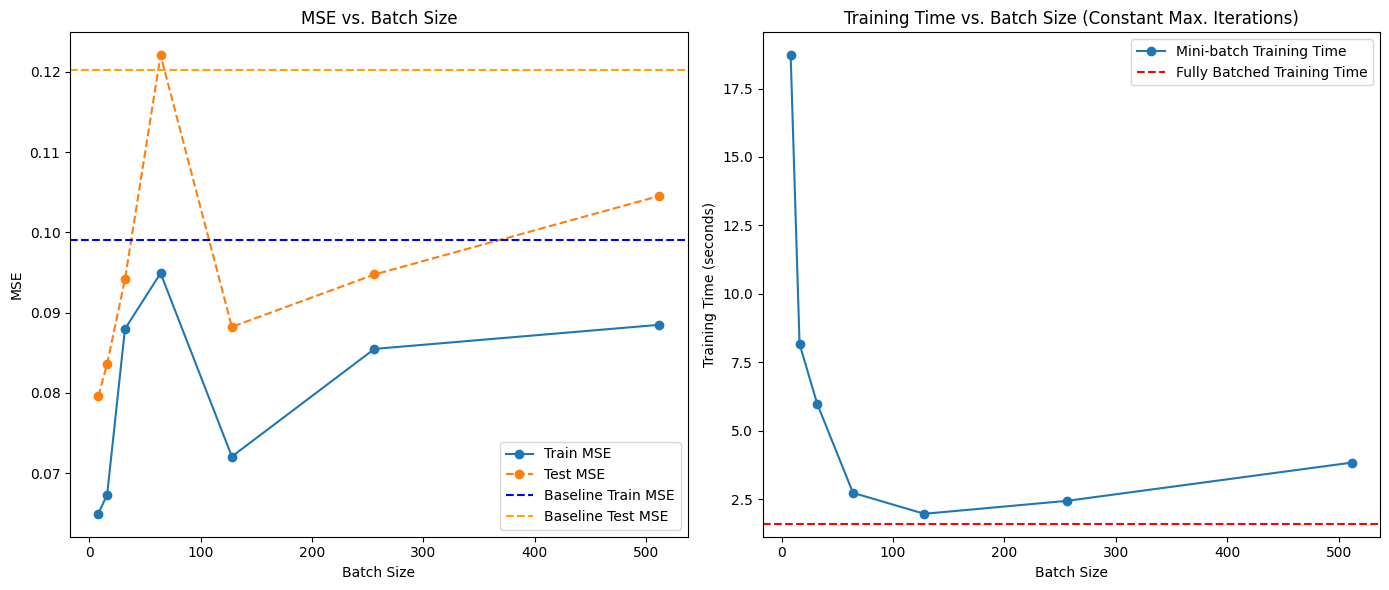

In [73]:
# First, we define a function to train and evaluate our Linear Regression model on varying batch sizes
def train_and_evaluate_sgd(batch_size, x_train, y_train, x_test, y_test, lr=0.0001, max_iters=1e4):

    start_time = time.time()
    # Initialize the model with the given batch size
    model = LinearRegressionSGD(lr=lr, max_iters=max_iters, batch_size=batch_size, record_history=True, verbose=False)

    # Fit the model on the training set
    model.fit(x_train, y_train)

    # Predict on both training and test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate performance metrics (e.g., Mean Squared Error) for both sets
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)

    # Record the end time
    end_time = time.time()

    # Calculate the time taken
    elapsed_time = end_time - start_time

    return train_mse, test_mse, model.w, elapsed_time


batch_sizes = [8, 16, 32, 64, 128, 256, 512]
train_mses = []
test_mses = []
weights = []
times = []

baseline_mse_train, baseline_mse_test, _,  baseline_time = train_and_evaluate_sgd(len(x_train_d1), x_train_d1, y_train_d1, x_test_d1, y_test_d1, 0.0001, max_iters=10000)
print("Baseline MSE (train):", baseline_mse_train)
print("Baseline MSE (test):", baseline_mse_test)
print("Training time - Baseline (s): ", baseline_time)

# Train the model with different batch sizes
# NOTE: We are keeping the max. iterations constant here, to measure the difference in effects for batch size
# Same goes for the train-test split (80-20)
for batch_size in batch_sizes:
  train_mse, test_mse, weight, elapsed_time = train_and_evaluate_sgd(batch_size, x_train_d1, y_train_d1, x_test_d1, y_test_d1, 0.0001, max_iters=10000)
  train_mses.append(train_mse)
  test_mses.append(test_mse)
  weights.append(weight)
  times.append(elapsed_time)
  print(f"Batch Size: {batch_size}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, Time: {elapsed_time:.4f} seconds")

# Plot the convergence weights for different batch sizes

plt.figure(figsize=(14, 6))

# Plot Train and Test MSE
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, train_mses, label='Train MSE', marker='o')
plt.plot(batch_sizes, test_mses, label='Test MSE', marker='o', linestyle='--')
plt.axhline(y=baseline_mse_train, color='b', linestyle='--', label='Baseline Train MSE')
plt.axhline(y=baseline_mse_test, color='orange', linestyle='--', label='Baseline Test MSE')
plt.xlabel('Batch Size')
plt.ylabel('MSE')
plt.title('MSE vs. Batch Size')
plt.legend()

# Plot Training time
plt.subplot(1, 2, 2)
plt.plot(batch_sizes, times, label='Mini-batch Training Time', marker='o')
plt.axhline(y=baseline_time, color='r', linestyle='--', label='Fully Batched Training Time')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Batch Size (Constant Max. Iterations)')
plt.legend()

plt.tight_layout()
plt.show()

**Analysis**

Convergence Speed Trends:
* The lower the batch size, the higher the execution time, even keeping max. iterations and learning rates constant.
* This could be due to a multitude of factors, notably:
  * Higher per-iteration overhead: Each weight update involves memory access and data transfer, which is an overhead incurred more often with more frequent weight updates for smaller batch sizes.
  * Higher batch-size models cna converge faster since they capture more of the dataset's trend per iteration
* _Note: In the big-picture trend, there sometimes seems to be a point where this trend reverses - Mid-size batch SGD seems to run faster than full-batch. This can be explained by the fact that full-batch SGD requires computing the gradient over the entire dataset at each iteration, which can be computationally expensive._


Model Performance Trends:
* We can observe that very small batch sizes have a performance very similar to that of the full-batched SGD model initially. Batch sizes between 16-128 increasingly surpass the accuracy of the full-batched model for both the train and test sets, and this performance slowly trends towards that of the baseline as we increase batch sizes.
* This can be explained by a variety of factors:
  * Models with smaller batch sizes may be overfitting the data to some extent
  * We seem to reach an equilibrium between under and over-fitting the test data around a batch size of 16, where we achieve the lowest training error.

Best configuration:
* For this model in specific, we believe the model with batch size 32 provides maximal optimality. It completes training in much less time than the model with batch size of 8, while also having the minimal test set error and a relatively small training set error.

##### **1.5 - Effects of Variation in Learning Rates (SGD)**
In this subsection, we will present the performance of linear regression with at least three different learning rates.


Learning rate: 5e-07, Train MSE: 0.1304, Test MSE: 0.1539, Time: 1.9166 seconds
Learning rate: 1e-06, Train MSE: 0.1279, Test MSE: 0.1524, Time: 1.9330 seconds
Learning rate: 1e-05, Train MSE: 0.1052, Test MSE: 0.1277, Time: 1.9223 seconds
Learning rate: 5e-05, Train MSE: 0.0828, Test MSE: 0.1080, Time: 1.9187 seconds
Learning rate: 0.0001, Train MSE: 0.0721, Test MSE: 0.0907, Time: 1.9340 seconds


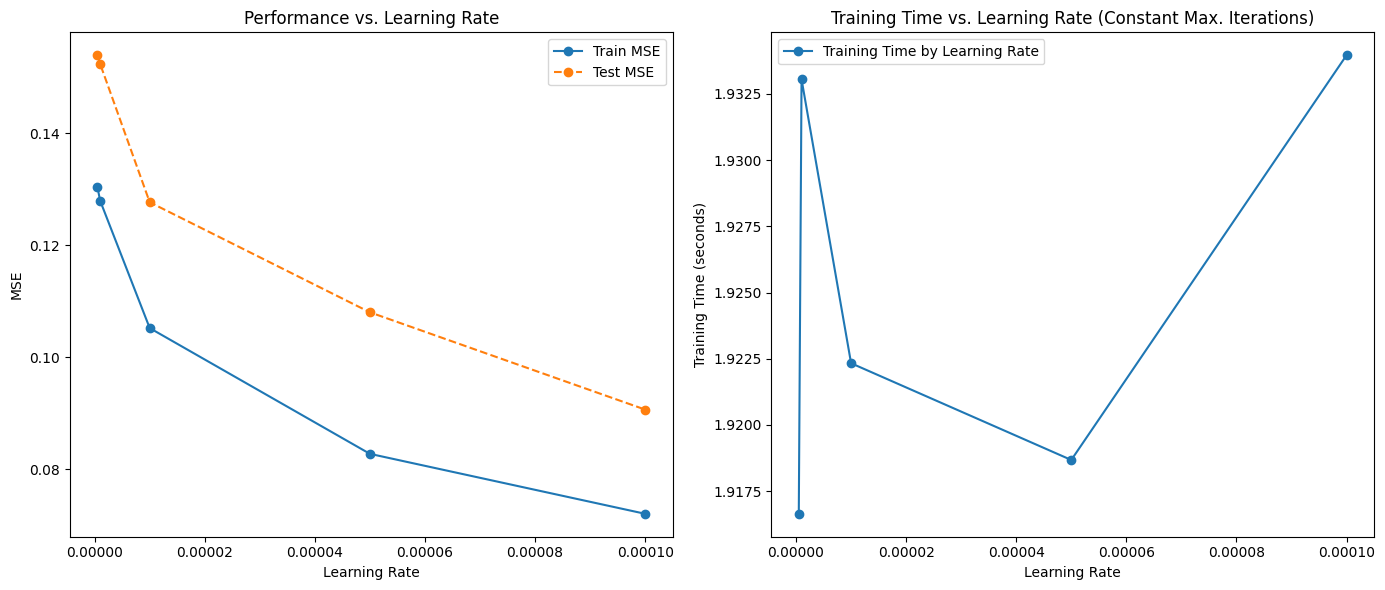

In [74]:
# We will re-use the function implemented in the previous cell to initialize and analyse LinearSGD models .
def train_and_evaluate_sgd(batch_size, x_train, y_train, x_test, y_test, lr=0.0001, max_iters=1e4):

    start_time = time.time()
    # Initialize the model with the given batch size
    model = LinearRegressionSGD(lr=lr, max_iters=max_iters, batch_size=batch_size, record_history=True, verbose=False)

    # Fit the model on the training set
    model.fit(x_train, y_train)

    # Predict on both training and test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate performance metrics (e.g., Mean Squared Error) for both sets
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)

    # Record the end time
    end_time = time.time()

    # Calculate the time taken
    elapsed_time = end_time - start_time

    return train_mse, test_mse, model.w, elapsed_time

# To measure the effect of learning rate efficiently, we will keep the other hyperparameters constant.
# Being considerate of training time, we will pick an optimal, larger-batched model from the
# last cell to make analyses on.
batch_size_a = 128
max_iters = 10000
train_mses = []
test_mses = []
weights = []
times = []

learning_rates = [0.0000005, 0.000001, 0.00001, 0.00005, 0.0001] # Seems to diverge at learning rates > 0.0001

for learning_rate in learning_rates:
  train_mse, test_mse, weight, elapsed_time = train_and_evaluate_sgd(batch_size_a, x_train_d1, y_train_d1, x_test_d1, y_test_d1, learning_rate, max_iters=max_iters)
  train_mses.append(train_mse)
  test_mses.append(test_mse)
  weights.append(weight)
  times.append(elapsed_time)
  print(f"Learning rate: {learning_rate}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, Time: {elapsed_time:.4f} seconds")

# Plot the convergence speeds for different leraning rates

plt.figure(figsize=(14, 6))

# Plot Train and Test MSE
plt.subplot(1, 2, 1)
plt.plot(learning_rates, train_mses, label='Train MSE', marker='o')
plt.plot(learning_rates, test_mses, label='Test MSE', marker='o', linestyle='--')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('Performance vs. Learning Rate')
plt.legend()

# Plot Training time
plt.subplot(1, 2, 2)
plt.plot(learning_rates, times, label='Training Time by Learning Rate', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Learning Rate (Constant Max. Iterations)')
plt.legend()

plt.tight_layout()
plt.show()


**Analysis**

Performance vs. Learning Rate:
* There is a clear trend between an increase in learning rate and an improvement in the model's performance.
* This can be explained by the fact that hyperparameters like batch size and max iterations are being kept constant, while an increase in learning rate lets the model converge more quickly at each iteration. This means that within the set amount of iterations, models with a higher learning rate are able to get closer and closer to the optimal weight value.
  * Note: This only holds for learning rates up to a certain value, since learning rates that are too large run the risk of diverging.


Training time vs. Learning Rate:
* There is no clear trend between an increase in learning rate and a change in the amount of time taken to train the model.
* This can be explained by the fact that a change in learning rate doesn't significantly change the computational complexity at each iteration of the model. Since all other hyperparameters are kept constant, and a change in learning rate still requires the same operations at each iteration, it is logical that there is a constant relation between the learning rate and the training time.

##### **1.6 - Analytical Solution and Mini Batch SGD Comparison**
In this subsection, we will compare analytical linear regression solution with mini-batch stochastic gradient descent based linear regression
solution, and discuss what we find.

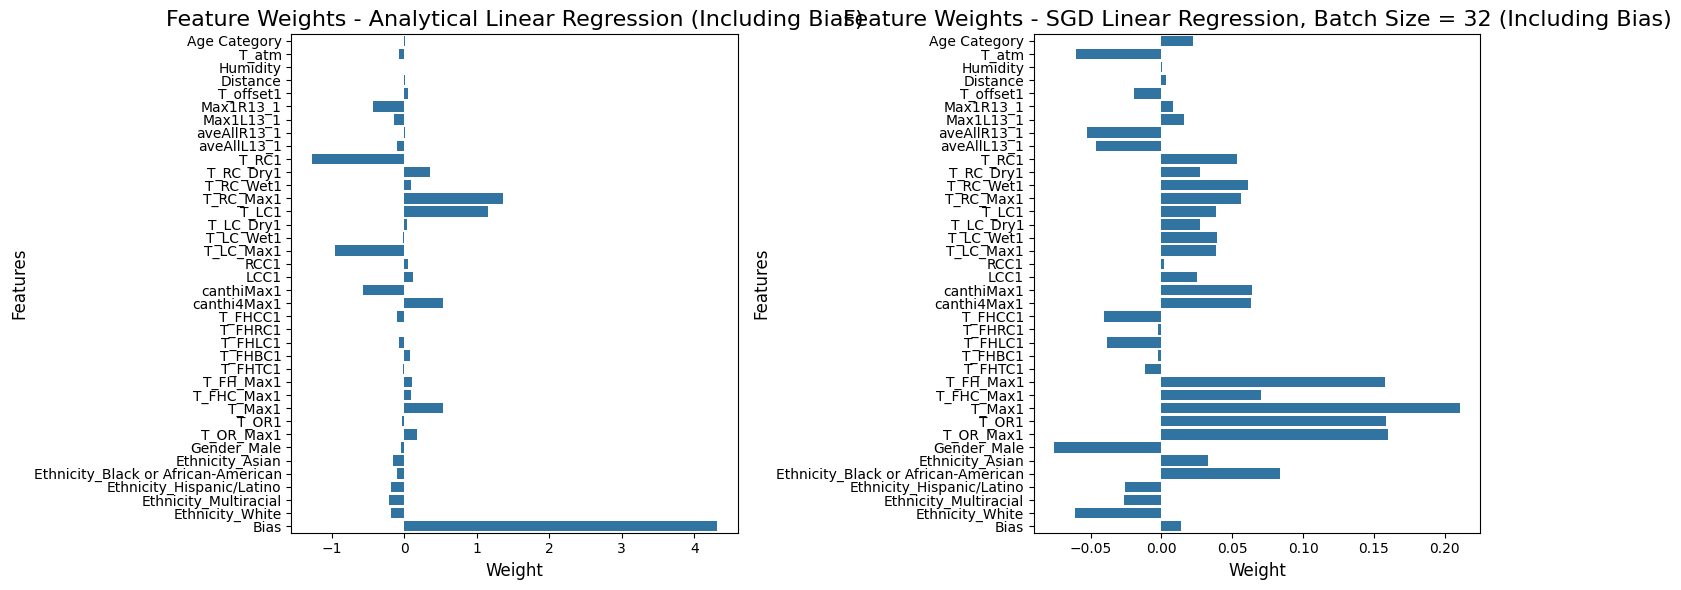

In [75]:
# To compare the analytical linear regression model with the SGD one fairly, we will use:
  # The same 80-20 train-test data split on both
  # The "optimal" SGD model we found in Section 1.4, as well as the singular Analytical Linear Regression model.

# First, we train our Analytical Linear Regression model.
analytical_start_time = time.time() # Measure training time

linear_model = LinearRegression(add_bias=True)
linear_model.fit(x_train_d1, y_train_d1)

analytical_end_time = time.time()
d1_feature_weights = linear_model.w

analytical_training_time = analytical_end_time - analytical_start_time

y_pred = linear_model.predict(x_test_d1) # Predictions on the test set
y_pred_train = linear_model.predict(x_train_d1) # Predictions on the training set


# Now, we can train our SGD Linear Regression model, using a function we have defined above.
sgd_train_mse, sgd_test_mse, sgd_weights, sgd_time = train_and_evaluate_sgd(32, x_train_d1, y_train_d1, x_test_d1, y_test_d1, 0.0001, max_iters=10000)

# Weight comparison:
feature_names = cleaned_d1_features_df.columns.tolist()  #get feature names
feature_names_w_bias = feature_names + ["Bias"] #add the bias as a feature

d1_analytical_feature_weights_df = pd.DataFrame({
    'Feature': feature_names_w_bias,
    'Weight': d1_feature_weights
})

d1_sgd_feature_weights_df = pd.DataFrame({
    'Feature': feature_names_w_bias,
    'Weight': sgd_weights
})

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

sns.barplot(x='Weight', y='Feature', data=d1_analytical_feature_weights_df, ax=axes[0])
axes[0].set_title("Feature Weights - Analytical Linear Regression (Including Bias)", fontsize=16)
axes[0].set_xlabel("Weight", fontsize=12)
axes[0].set_ylabel("Features", fontsize=12)

# Second plot
sns.barplot(x='Weight', y='Feature', data=d1_sgd_feature_weights_df, ax=axes[1])
axes[1].set_title("Feature Weights - SGD Linear Regression, Batch Size = 32 (Including Bias)", fontsize=16)  # Adjust title as needed
axes[1].set_xlabel("Weight", fontsize=12)
axes[1].set_ylabel("Features", fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [76]:
# We can also compare training times:
print("Training time - Analytical Linear Regression:", analytical_training_time, "seconds.")
print("Training time - SGD Linear Regression:", sgd_time, "seconds.")


# Finally, we can compare performance on both the training set and test set
d1_mse_train = np.mean((y_train_d1 - y_pred_train) ** 2)
d1_mse = np.mean((y_test_d1 - y_pred) ** 2)
print("\nAnalytical Linear Regression MSE - Training set:", d1_mse_train)
print("Analytical Linear Regression MSE - Test set:", d1_mse)

print("\nSGD Linear Regression MSE - Training set:", sgd_train_mse)
print("SGD Linear Regression MSE - Test set:", sgd_test_mse)


Training time - Analytical Linear Regression: 0.008130073547363281 seconds.
Training time - SGD Linear Regression: 5.541916370391846 seconds.

Analytical Linear Regression MSE - Training set: 0.060014418204594036
Analytical Linear Regression MSE - Test set: 0.07324051019696783

SGD Linear Regression MSE - Training set: 0.12911738526947905
SGD Linear Regression MSE - Test set: 0.12952515359883798


**Analysis**

Comparing these two models highlights the advantage of being able to solve directly for the optimal solution during linear regression:

1. Significantly lower training time for Analytical Linear Regression:

The analytical model uses matrix computation to directly compute the direct weight set, giving it an optimal solution in very little time. It does not have to go through thousands of iterations to optimize the weight set, like the SGD model does.


2. Lower error for both train and test data for Analytical Linear Regression

The Analytical Linear Regression model already solved for the optimal weight set, whereas we "interrupt" the SGD model from its optimizations after 10 000 iterations. Therefore, the Analytical model has already found its most optimal solution on the training set, reflcted as lower MSE values in both the train and test sets.


-> We also observe an interesting difference in the weights computed by each model

* Both models behave in relatively similar ways when considering the sign of the weights -- Most positively-weighted parameters in the analytical model are also positively-weighted in the SGD model, and vice-versa.

* However, we notice a significant difference in the magnitude of the weights - The SGD model's weighs are of a much higher magnitude than those of the Analytical model.
  * This could be the result of the SGD model not having enough iterations to fully converge to an optimal weight set.

##### **1.7 - Effects of Data Representation on Model Speed**

In this subsection, we will analyse whether the representation of the feature data has any effects on the model performance in both Analytical Linear Regression and SGD Linear Regression.

- We will be comparing training times for both models on our initial, preprocessed dataset 1 to those of the same dataset with alternate numerical representations.

In [77]:
# We have been using the following cleaned d1 datasets, where each feature
# has been downcasted as much as possible
# We now have our cleaned features and targets datasets:
print("Original cleaned d1 datasets: ")
print(cleaned_d1_features_df.info())
print("\n##############################################\n")
print(cleaned_d1_targets_df.info())

# We can now create dataframes of much higher precision for our data.
precise_d1_features_df = cleaned_d1_features_df.astype(np.float64)
precise_d1_targets_df = cleaned_d1_targets_df.astype(np.float64)

print("High precision d1 datasets: ")
print(precise_d1_features_df.info())
print("\n##############################################\n")
print(precise_d1_targets_df.info())

Original cleaned d1 datasets: 
<class 'pandas.core.frame.DataFrame'>
Index: 1018 entries, 0 to 1019
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age Category                         1018 non-null   int8   
 1   T_atm                                1018 non-null   float32
 2   Humidity                             1018 non-null   float32
 3   Distance                             1018 non-null   float32
 4   T_offset1                            1018 non-null   float32
 5   Max1R13_1                            1018 non-null   float32
 6   Max1L13_1                            1018 non-null   float32
 7   aveAllR13_1                          1018 non-null   float32
 8   aveAllL13_1                          1018 non-null   float32
 9   T_RC1                                1018 non-null   float32
 10  T_RC_Dry1                            1018 non-null   float32
 11  T_RC

In [78]:
# We gather our x and y train and test data as follows
total_cleaned_d1_data = pd.concat([cleaned_d1_features_df, cleaned_d1_targets_df], axis=1)

  # 2. Shuffle the dataframe
shuffled_total_d1_data = total_cleaned_d1_data.sample(frac=1, random_state=42).reset_index(drop=True)
d1_split_index = int(0.8 * len(shuffled_total_d1_data))

  # 3. Split the data into train and test datasets
train_d1_data = shuffled_total_d1_data[:d1_split_index]
test_d1_data = shuffled_total_d1_data[d1_split_index:]

  # 4. Separate features and targets
x_train_d1 = train_d1_data[cleaned_d1_features_df.columns].values
y_train_d1 = train_d1_data["aveOralM"].values
x_test_d1 = test_d1_data[cleaned_d1_features_df.columns].values
y_test_d1 = test_d1_data["aveOralM"].values


# We can do something similar with the new, precise datasets
total_precise_cleaned_d1_data = pd.concat([precise_d1_features_df, precise_d1_targets_df], axis=1)

  # 2. Shuffle the dataframe
shuffled_precise_total_d1_data = total_precise_cleaned_d1_data.sample(frac=1, random_state=42).reset_index(drop=True)
d1_precise_split_index = int(0.8 * len(shuffled_precise_total_d1_data))

  # 3. Split the data into train and test datasets
precise_train_d1_data = shuffled_precise_total_d1_data[:d1_precise_split_index]
precise_test_d1_data = shuffled_precise_total_d1_data[d1_precise_split_index:]

  # 4. Separate features and targets
precise_x_train_d1 = precise_train_d1_data[precise_d1_features_df.columns].values
precise_y_train_d1 = precise_train_d1_data["aveOralM"].values
precise_x_test_d1 = precise_test_d1_data[precise_d1_features_df.columns].values
precise_y_test_d1 = precise_test_d1_data["aveOralM"].values



In [79]:
# From section 1.6, we already have a measure of time and accuracy for running our models on
# regular, condensed data.

print("Training time - Analytical Linear Regression:", analytical_training_time, "seconds.")
print("Training time - SGD Linear Regression:", sgd_time, "seconds.")


# Finally, we can compare performance on both the training set and test set
print("\nAnalytical Linear Regression MSE - Training set:", d1_mse_train)
print("Analytical Linear Regression MSE - Test set:", d1_mse)

print("\nSGD Linear Regression MSE - Training set:", sgd_train_mse)
print("SGD Linear Regression MSE - Test set:", sgd_test_mse)


# We can now train and measure our models on the more precise datasets.
# First, we train our Analytical Linear Regression model.
p_analytical_start_time = time.time() # Measure training time

linear_model = LinearRegression(add_bias=True)
linear_model.fit(precise_x_train_d1, precise_y_train_d1)

p_analytical_end_time = time.time()
d1_feature_weights = linear_model.w

p_analytical_training_time = p_analytical_end_time - p_analytical_start_time

y_pred = linear_model.predict(precise_x_test_d1) # Predictions on the test set
y_pred_train = linear_model.predict(precise_x_train_d1) # Predictions on the training set

# Finally, we can compare performance on both the training set and test set
p_d1_mse_train = np.mean((precise_y_train_d1 - y_pred_train) ** 2)
p_d1_mse = np.mean((precise_y_test_d1 - y_pred) ** 2)

p_sgd_train_mse, p_sgd_test_mse, p_sgd_weights, p_sgd_time = train_and_evaluate_sgd(32, precise_x_train_d1, precise_y_train_d1, precise_x_test_d1, precise_y_test_d1, 0.0001, max_iters=10000)

print("\n\nPRECISE WEIGHTS: ")
print("\nTraining time - Analytical Linear Regression (Precise features):", p_analytical_training_time, "seconds.")
print("Training time - SGD Linear Regression (Precise features):", p_sgd_time)

print("\nTraining set MSE for Analytical Linear Regression (Precise):", p_sgd_train_mse)
print("\nTest set MSE for Analytical Linear Regression (Precise):", p_sgd_test_mse)

print("\nTraining set MSE for SGD Linear Regression (Precise):", p_d1_mse_train)
print("\Test set MSE for SGD Linear Regression (Precise):", p_d1_mse)

Training time - Analytical Linear Regression: 0.008130073547363281 seconds.
Training time - SGD Linear Regression: 5.541916370391846 seconds.

Analytical Linear Regression MSE - Training set: 0.060014418204594036
Analytical Linear Regression MSE - Test set: 0.07324051019696783

SGD Linear Regression MSE - Training set: 0.12911738526947905
SGD Linear Regression MSE - Test set: 0.12952515359883798


PRECISE WEIGHTS: 

Training time - Analytical Linear Regression (Precise features): 0.0020978450775146484 seconds.
Training time - SGD Linear Regression (Precise features): 4.744921922683716

Training set MSE for Analytical Linear Regression (Precise): 0.069271588457467

Test set MSE for Analytical Linear Regression (Precise): 0.08708351496477262

Training set MSE for SGD Linear Regression (Precise): 0.060014418204594036
\Test set MSE for SGD Linear Regression (Precise): 0.07324051019696783


**Analysis**

Training time:
* We do observe a slightly higehr training time for both models when using the more precise dataset with larger representations.
* This can be attributed to the fact that larger types can occupy more space in RAM during data processing, leading to higher training times.

Accuracy:
* As predicted, there is negligible effect on the accuracy of each model between the precise and less-precise data representations, since the underlying data stored in each is identical.

#### **Dataset 2**

In this subsection, we will report the performance of the **logistic regression model on dataset 2**. We will start out with a 80-20 train-test split, and report the performance on both the training set and test set. From there, we will compare the performance of the model using the full-batch Gradient Descent solution to the mini-batch Stochastic Gradient Descent (SGD) solution, and examine the effects in performance by varying the size of the training data, the batch size, and the learning rate.<br><br>

First we must prepare the data so that we can train and fit it:


In [80]:
# To avoid any bias in our train-test set split, we will first shuffle our data

  # 1. Combine the features and targets
total_cleaned_d2_data = pd.concat([cleaned_d2_features_df, cleaned_d2_targets_df], axis=1)

  # 2. Shuffle the dataframe
shuffled_total_d2_data = total_cleaned_d2_data.sample(frac=1, random_state=42).reset_index(drop=True)
d2_split_index = int(0.8 * len(shuffled_total_d2_data))

  # 3. Split the data into train and test datasets
train_d2_data = shuffled_total_d2_data[:d2_split_index]
test_d2_data = shuffled_total_d2_data[d2_split_index:]

  # 4. Separate features and targets
x_train_d2 = train_d2_data[cleaned_d2_features_df.columns].values
y_train_d2 = train_d2_data["Diabetes_binary"].values
x_test_d2 = test_d2_data[cleaned_d2_features_df.columns].values
y_test_d2 = test_d2_data["Diabetes_binary"].values


# We can now initialize and train the model.
logistic_model = LogisticRegression(add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False)
logistic_model.fit(x_train_d2, y_train_d2)

d2_feature_weights = logistic_model.w

y_pred = logistic_model.predict(x_test_d2)


##### **2.1 - Model Performance**
Now that we have trained the model, we can analyze its performance. For the Logistic Regression model, we will use the following popular performance metrics:

* **Accuracy Score** - The ratio of correctly predicted instances to the total instances (i.e. the model's overall performance in terms of correctness).

* **Precision Score** - The ratio of true positive predictions to total predicted positives (i.e. the model's ability to produce correct positive predictions and avoid false positives).

* **Recall Score** - The ratio of true positive predictions to total actual positives (i.e. the model's effectiveness in identifying actual positive cases and avoiding false negatives).

* **F1 Score** - The harmonic mean of precision and recall (i.e. a balanced metric that considers both precision and recall scores, a better metric  for overall performance when the dataset is imbalanced, like it is in this case).

* **Confusion Matrix** - A table displaying true positives, true negatives, false positives, and false negatives (a breakdown of model predictions, helping identify specific areas of misclassification).







Performance measures on test set - Dataset 2 - Full Batch Logistic Regression: 
Accuracy: 0.86
Precision: 0.53
Recall: 0.15
F1 score: 0.23
[[42722   959]
 [ 5992  1063]]


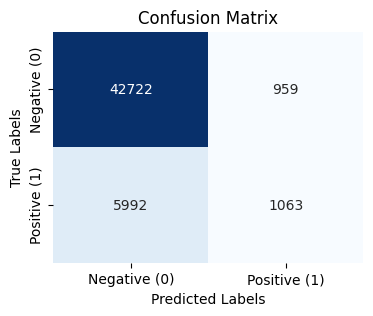

In [81]:
# Now, we can measure performance according to popular performance metrics
print("Performance measures on test set - Dataset 2 - Full Batch Logistic Regression: ")

## Accuracy Score
d2_accuracy = accuracy_score(y_test_d2, y_pred)
print(f"Accuracy: {d2_accuracy:.2f}")

## Precision Score
d2_precision = precision_score(y_test_d2, y_pred)
print(f"Precision: {d2_precision:.2f}")

## Recall Score
d2_recall = recall_score(y_test_d2, y_pred)
print(f"Recall: {d2_recall:.2f}")

## F1 Score
d2_f1 = f1_score(y_test_d2, y_pred)
print(f"F1 score: {d2_f1:.2f}")

## Confusion Matrix
d2_cm = confusion_matrix(y_test_d2, y_pred)
print(d2_cm)
plt.figure(figsize=(4, 3))
sns.heatmap(d2_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**Performance Analysis**  
* The Accuracy Score (0.86) is relatively high - indicating that overall the model is successful in predicting correct output.
However,
* The Precision Score (0.53) is relatively concerning as this indicates that the model correctly predicts true positives just above half the time

* The Recall Score (0.15) is very concerning given that this suggests the model identifies only a small portion of the true positive cases of diabetes.

* F1 Score (0.23) indicates that overall the performance of our model is limited.



##### **2.2 - Weights Analysis**
In this subsection, we will present the weights assigned to each feature in our trained logistic regression model. We will discuss how these features influence the likelihood of having pre-diabetes or diabetes, as well as what the weights reveal about the model's overall performance.

Dataset 2 - Full-Batch Logistic Regression Feature Weights (including bias):
                  Feature    Weight
0                 HighBP  0.374360
1               HighChol  0.292632
2              CholCheck  0.225925
3                    BMI  0.399003
4                 Smoker -0.004883
5                 Stroke  0.026676
6   HeartDiseaseorAttack  0.064280
7           PhysActivity -0.021703
8                 Fruits -0.024684
9                Veggies -0.013438
10     HvyAlcoholConsump -0.174032
11         AnyHealthcare  0.021856
12           NoDocbcCost  0.002209
13               GenHlth  0.568887
14              MentHlth -0.028253
15              PhysHlth -0.061873
16              DiffWalk  0.050538
17                   Sex  0.128767
18                   Age  0.375166
19             Education -0.028629
20                Income -0.111036
21                  Bias -2.414596


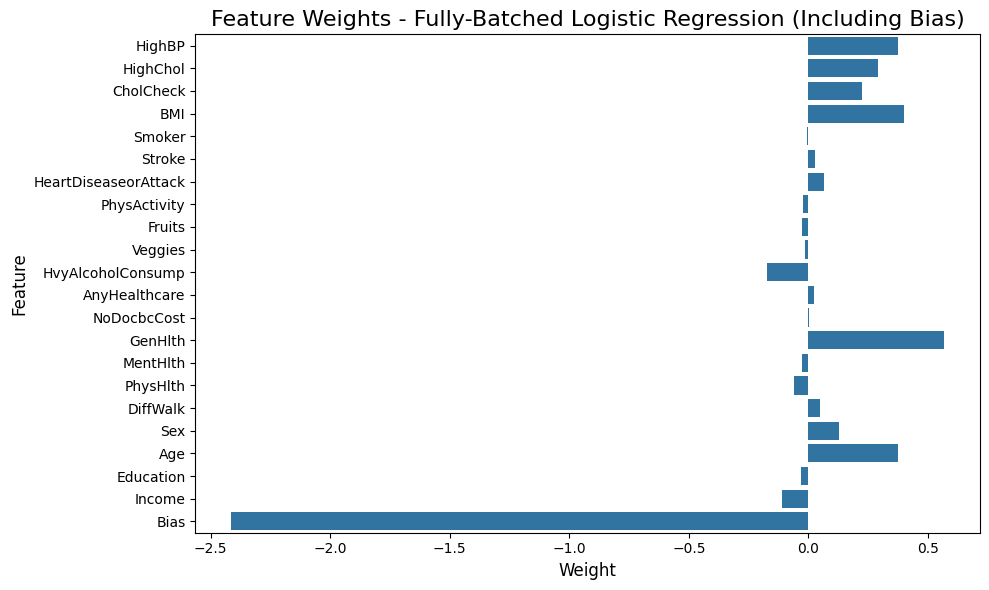

In [82]:
# Reassociate the weights from when we ran the model to the cleaned feature names:

feature_names = cleaned_d2_features_df.columns.tolist()  #get feature names
feature_names_w_bias = feature_names + ["Bias"] #add the bias as a feature

d2_feature_weights_df = pd.DataFrame({
    'Feature': feature_names_w_bias,
    'Weight': d2_feature_weights
})

print("Dataset 2 - Full-Batch Logistic Regression Feature Weights (including bias):\n", d2_feature_weights_df)

# Plotting the weights as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=d2_feature_weights_df)

# Adding title and labels
plt.title("Feature Weights - Fully-Batched Logistic Regression (Including Bias)", fontsize=16)
plt.xlabel("Weight", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

**Analysis**<br>
The feature weights from the logistic regression model indicate that higher BMI, age, high blood pressure, and especially general health are strongly associated with an increased likelihood of diabetes, while heavy alcohol consumption and certain lifestyle factors like smoking and physical activity have a negative but minor influence. The negative bias term suggests that, in the absence of other features, the model predicts a lower probability of diabetes.<br><br>

Overall, the presence of several significant positive weights associated with features that are generally linked to increase the likelihood of diabetes (e.g. general health, BMI) implies that the model has the potential to perform well in predicting diabetes.

##### **2.3 - Effects of Variation in Size of Training Data**
In this subsection, we will sample growing subsets of the training data (20%,30%,...80%). We will observe and explain how the size of training
data affects the performance for both models. For each model, we will plot two curves as a function of training size, one for performance in train and one for test.


[0.8660911384421318, 0.865237044044991, 0.8647804320403658, 0.864356669820246, 0.8637325239146432, 0.863703428391224, 0.8635929123304951]
[0.8630410359508042, 0.8629037707798352, 0.8628915694313045, 0.8628114159571113, 0.8633021917376222, 0.8633317565436771, 0.8629966887417219]


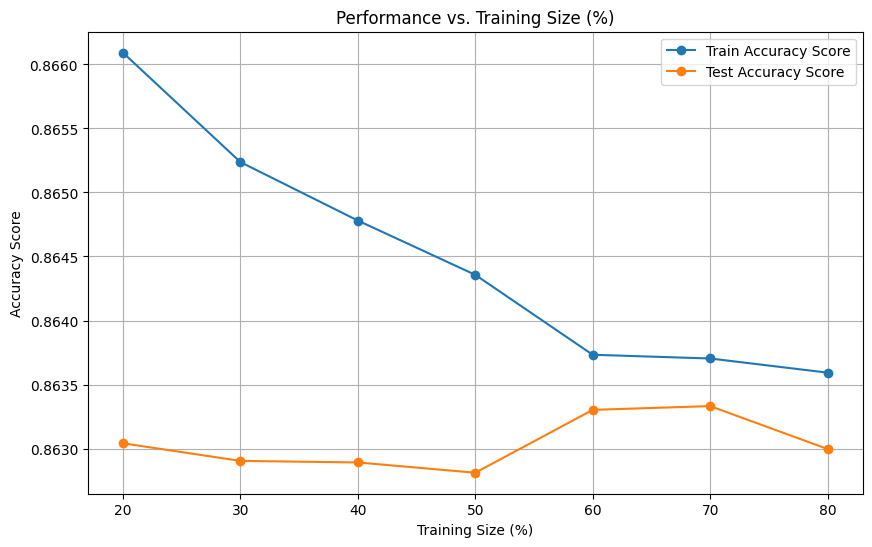

[0.2519268883505836, 0.2369047619047619, 0.23886392633272313, 0.242637672227847, 0.24145119408989504, 0.24263854554557687, 0.24435648969564625]
[0.236673715431302, 0.23618736861920747, 0.23721627252458058, 0.24029687841082734, 0.24023662156980885, 0.23997077091706248, 0.23421835408174507]


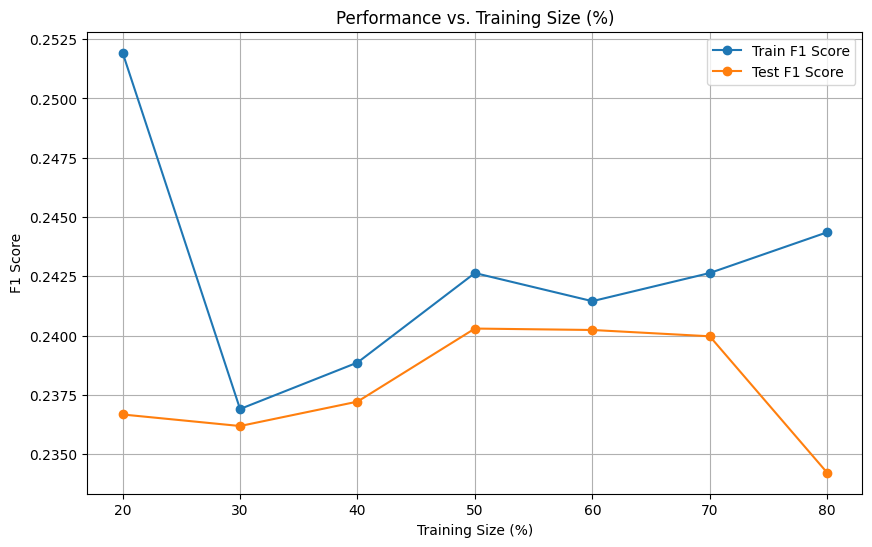

In [83]:
percentages = np.arange(0.2, 0.9, 0.1)
d2_train_f1scores, d2_test_f1scores = [], []
d2_train_acc_scores, d2_test_acc_scores = [], []

for percentage in percentages:
  sub_index = int(percentage * len(shuffled_total_d2_data))
  train_subset = shuffled_total_d2_data[:sub_index]
  test_subset = shuffled_total_d2_data[sub_index:]

  x_train = train_subset[cleaned_d2_features_df.columns].values
  y_train = train_subset["Diabetes_binary"].values
  x_test = test_subset[cleaned_d2_features_df.columns].values
  y_test = test_subset["Diabetes_binary"].values

  curr_logistic_model = LogisticRegression(add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False)
  curr_logistic_model.fit(x_train, y_train)

  y_train_pred = curr_logistic_model.predict(x_train)
  y_test_pred = curr_logistic_model.predict(x_test)


  #F1 Scores
  train_f1 = f1_score(y_train, y_train_pred)
  test_f1 = f1_score(y_test, y_test_pred)

  d2_train_f1scores.append(train_f1)
  d2_test_f1scores.append(test_f1)

  #Accuracy Scores
  train_acc = accuracy_score(y_train, y_train_pred)
  test_acc = accuracy_score(y_test, y_test_pred)

  d2_train_acc_scores.append(train_acc)
  d2_test_acc_scores.append(test_acc)

def display_test_size_results(d2_train_scores, d2_test_scores, score, modifier):
  print(d2_train_scores)
  print(d2_test_scores)
  # Plotting the performance as a function of the modifier (e.g. training size, batch size)
  plt.figure(figsize=(10, 6))
  plt.plot(percentages * 100, d2_train_scores, label=f'Train {score}', marker='o')
  plt.plot(percentages * 100, d2_test_scores, label=f'Test {score}', marker='o')
  plt.title(f'Performance vs. {modifier}')
  plt.xlabel(f'{modifier}')
  plt.ylabel(score)
  plt.legend()
  plt.grid(True)
  plt.show()

display_test_size_results(d2_train_acc_scores, d2_test_acc_scores, "Accuracy Score", "Training Size (%)")
display_test_size_results(d2_train_f1scores, d2_test_f1scores, "F1 Score", "Training Size (%)")


**Trends and Explanations in the above graphs:**
* Initial high training accuracy (\< 50%), followed by gradual decline:
  * At first, the model overfits, learning specific patterns or noise in the small training set, leading to lower accuracy and F1 scores for the test set.
  * As training data grows, the model becomes exposed to more surprising patterns, slightly reducing training accuracy.

* Decreasing Performance from 70% to 80% Training Size:
  * The smaller test set provides fewer samples to evaluate, making performance measurement less reliable.
  * As a result, overfitting becomes more likely as the model learns very specific training data patterns, reducing generalization.

* Peak Performance around 60-70% Training Size:
  * At this size, the model has enough data to learn general patterns without overfitting. The test set remains large enough to reliably evaluate performance, leading to the best test accuracy and f1 scores.
  * As the training set increases beyond 70%, test accuracy declines due to overfitting and smaller test sets

* Fluctuating F1 Scores:
  * Smaller test sets make precision-recall trade-offs less stable, particularly with more imbalanced proportions.<br>
  


Thus, Somewhere between a 60-70% train-test split achieves the best balance between model learning and generalization.

##### **2.4 - Effects of Variation in Size of Batch (SGD)**
In this subsection, we will be comparing full-batch gradient descent  (keeping the original 80-20 train-test split) to our mini-batch Stochastic Gradient Descent (SGD) implementation in order to test the effects of different minibatch sizes (e.g. 32, 64, 128, 256, 512, and 1024) on performance (measured by compute time and F1 score), and to ultimately determine the higher performing model and method of optimization.


Baseline F1 (train): 0.2444
Baseline F1 (test): 0.2342
Training time - Baseline (s):  274.47154664993286
Batch Size: 32, Train F1: 0.2143, Test F1: 0.2117, Time: 463.9391 seconds
Batch Size: 64, Train F1: 0.2209, Test F1: 0.2159, Time: 314.4825 seconds
Batch Size: 128, Train F1: 0.2563, Test F1: 0.2460, Time: 243.0541 seconds
Batch Size: 256, Train F1: 0.2230, Test F1: 0.2178, Time: 230.9598 seconds
Batch Size: 512, Train F1: 0.2450, Test F1: 0.2388, Time: 295.9408 seconds
Batch Size: 1024, Train F1: 0.2236, Test F1: 0.2175, Time: 261.3483 seconds


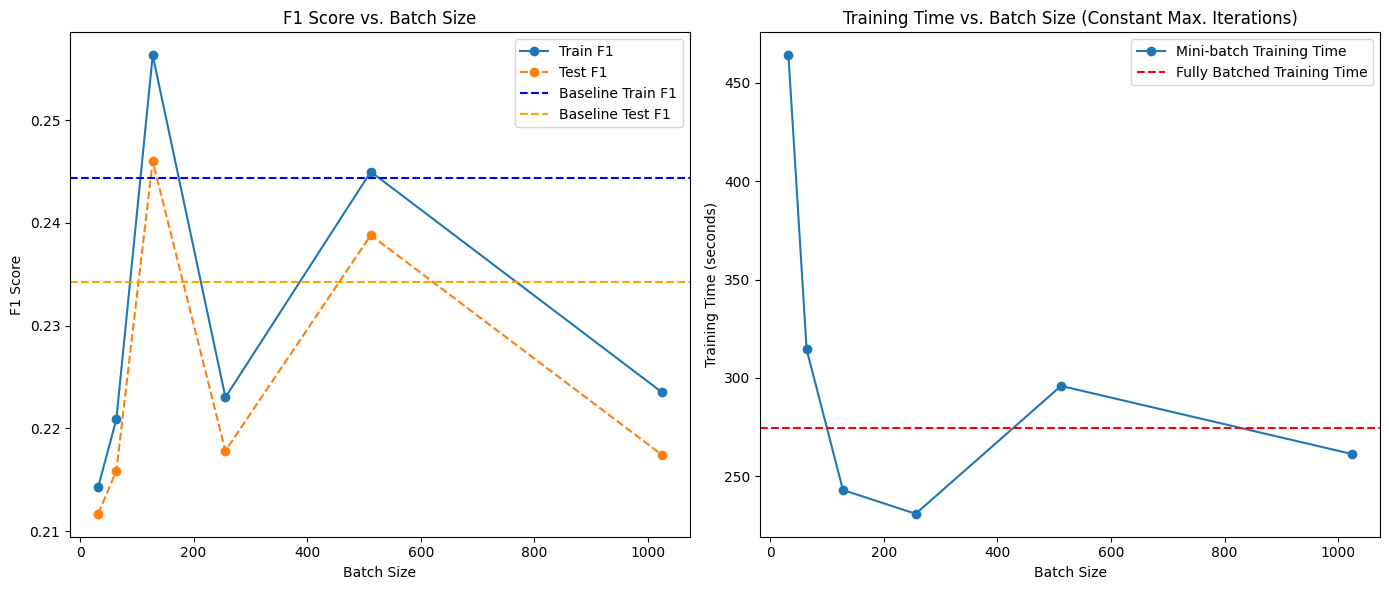

In [84]:
# First, we define a function to train and evaluate our Logistic Regression model on varying batch sizes
def train_and_evaluate_sgd(batch_size, x_train, y_train, x_test, y_test, lr=0.01, max_iters=1e4):

    start_time = time.time()
    # Initialize the model with the given batch size
    model = LogisticRegressionSGD(add_bias=True, lr=lr, max_iters=max_iters, epsilon=1e-8, batch_size=batch_size, record_history=True, verbose=False)

    # Fit the model on the training set
    model.fit(x_train, y_train)

    # Predict on both training and test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Record the end time
    end_time = time.time()

    # Calculate performance metrics (e.g., F1 score) for both sets
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Calculate the time taken
    elapsed_time = end_time - start_time

    return train_f1, test_f1, model.w, elapsed_time



batch_sizes = [32, 64, 128, 256, 512, 1024]
train_f1s = []
test_f1s = []
weights = []
times = []

# Full Batch - baseline
baseline_f1_train, baseline_f1_test, _,  baseline_time = train_and_evaluate_sgd(len(x_train_d2), x_train_d2, y_train_d2, x_test_d2, y_test_d2, lr=0.1, max_iters=2000)
print(f"Baseline F1 (train): {baseline_f1_train:.4f}")
print(f"Baseline F1 (test): {baseline_f1_test:.4f}")
print("Training time - Baseline (s): ", baseline_time)

# Train the model with different batch sizes
# NOTE: We are keeping the max. iterations constant here, to measure the difference in effects for batch size
# Same goes for the train-test split (80-20)
for batch_size in batch_sizes:
  train_f1, test_f1, weight, elapsed_time = train_and_evaluate_sgd(batch_size, x_train_d2, y_train_d2, x_test_d2, y_test_d2, lr=0.1, max_iters=2000)
  train_f1s.append(train_f1)
  test_f1s.append(test_f1)
  weights.append(weight)
  times.append(elapsed_time)
  print(f"Batch Size: {batch_size}, Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}, Time: {elapsed_time:.4f} seconds")

# Plot the convergence weights for different batch sizes

plt.figure(figsize=(14, 6))

# Plot Train and Test F1
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, train_f1s, label='Train F1', marker='o')
plt.plot(batch_sizes, test_f1s, label='Test F1', marker='o', linestyle='--')
plt.axhline(y=baseline_f1_train, color='b', linestyle='--', label='Baseline Train F1')
plt.axhline(y=baseline_f1_test, color='orange', linestyle='--', label='Baseline Test F1')
plt.xlabel('Batch Size')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Batch Size')
plt.legend()

# Plot Training time
plt.subplot(1, 2, 2)
plt.plot(batch_sizes, times, label='Mini-batch Training Time', marker='o')
plt.axhline(y=baseline_time, color='r', linestyle='--', label='Fully Batched Training Time')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Batch Size (Constant Max. Iterations)')
plt.legend()

plt.tight_layout()
plt.show()

**Trends and Explanations of the above graphs:**

* Initial spike in F1 score as the batch size increases: 
  * as the batch size increases from 32 to size 128, we notice a significant 20% increase in both the train and test f1 scores. This comes as no surprise as smaller batch sizes result in noisier updates to the weights during training and therefore  a poorer performance. 
  * We have a peak at batch size 128, one of the only batch sizes to exceed the F1 score baseline comparison. This suggests that this batch size offers a good balance between update stability and convergence speed, and that therefore a batch size around this number would be optimal for overall model performance.
    
* Decreasing Training Time: 
  * There is a significant decrease in training time between batch size 32 and 256. This is to be expected as larger batch sizes allow the model to process more data per iteration, reducing the total number of iterations needed to complete training, while smaller batch sizes result in higher training times due to the higher number of gradient updates. 
  * There is a slight rebound in training time past batch size 256, however this is most likely due to inefficiencies due to memory overhead.

* Full-Batch vs. Mini-batch Stochastic Gradient Descent (Baseline Comparison):
  * Overall, increasing the batch size leads to a faster training time, and, on average, higher performance. Higher performance can be achieved depending on the specific batch size. It is therefore a game of trial and error to determine what is ultimately the ideal batch size to optimize performance and training time.



##### **2.5 - Effects of Variation in Learning Rates (SGD)**
In this subsection, we will present the performance of the different logistic regression models with at least three different learning rates.


Learning rate: 0.001, Train F1 Score: 0.2449, Test F1 Score: 0.2348, Time: 111.7606 seconds
Learning rate: 0.01, Train F1 Score: 0.2398, Test F1 Score: 0.2315, Time: 113.7644 seconds
Learning rate: 0.025, Train F1 Score: 0.2517, Test F1 Score: 0.2417, Time: 101.5512 seconds
Learning rate: 0.05, Train F1 Score: 0.2463, Test F1 Score: 0.2410, Time: 100.8333 seconds
Learning rate: 0.1, Train F1 Score: 0.2419, Test F1 Score: 0.2364, Time: 99.4960 seconds
Learning rate: 0.2, Train F1 Score: 0.2221, Test F1 Score: 0.2172, Time: 100.8176 seconds
Learning rate: 0.25, Train F1 Score: 0.2209, Test F1 Score: 0.2189, Time: 100.3404 seconds
Learning rate: 0.35, Train F1 Score: 0.2503, Test F1 Score: 0.2419, Time: 101.3023 seconds
Learning rate: 0.5, Train F1 Score: 0.2190, Test F1 Score: 0.2169, Time: 101.2707 seconds
Learning rate: 0.65, Train F1 Score: 0.2043, Test F1 Score: 0.1971, Time: 100.6438 seconds
Learning rate: 0.8, Train F1 Score: 0.1528, Test F1 Score: 0.1545, Time: 104.3586 seconds
Le

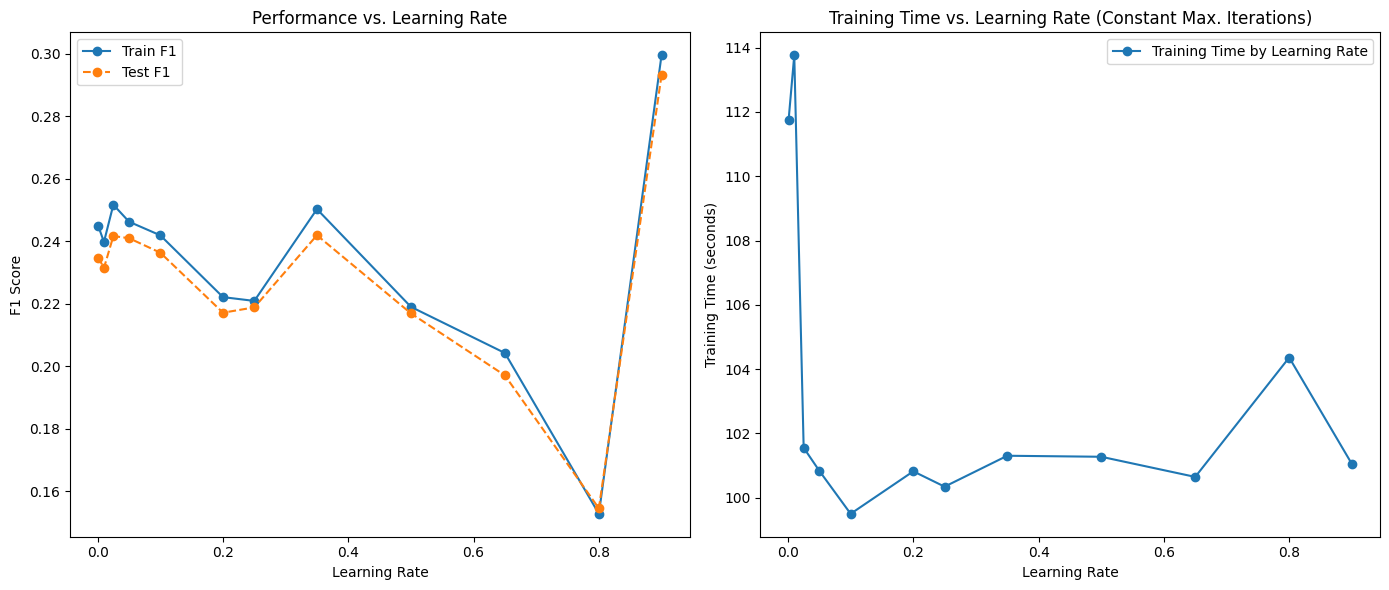

In [85]:
# We will re-use the function implemented in the previous cell to initialize and analyse LogisticRegressionSGD model.
def train_and_evaluate_sgd(batch_size, x_train, y_train, x_test, y_test, lr=0.01, max_iters=1e4):

    start_time = time.time()
    # Initialize the model with the given batch size
    model = LogisticRegressionSGD(add_bias=True, lr=lr, max_iters=max_iters, epsilon=1e-8, batch_size=batch_size, record_history=True, verbose=False)

    # Fit the model on the training set
    model.fit(x_train, y_train)

    # Predict on both training and test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Record the end time
    end_time = time.time()

    # Calculate performance metrics (e.g., F1 score) for both sets

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Calculate the time taken
    elapsed_time = end_time - start_time

    return train_f1, test_f1, model.w, elapsed_time



# To measure the effect of learning rate efficiently, we will keep the other hyperparameters constant.
# Being considerate of training time, we will pick an optimal, larger-batched model from the
# last cell to make analyses on.
batch_size_a = 128
max_iters = 1000
train_f1s = []
test_f1s = []
weights = []
times = []

learning_rates = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.25, 0.35, 0.5, 0.65, 0.8, 0.9]

for learning_rate in learning_rates:
  train_f1, test_f1, weight, elapsed_time = train_and_evaluate_sgd(batch_size_a, x_train_d2, y_train_d2, x_test_d2, y_test_d2, learning_rate, max_iters=max_iters)
  train_f1s.append(train_f1)
  test_f1s.append(test_f1)
  weights.append(weight)
  times.append(elapsed_time)
  print(f"Learning rate: {learning_rate}, Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}, Time: {elapsed_time:.4f} seconds")

# Plot the convergence speeds for different leraning rates

plt.figure(figsize=(14, 6))

# Plot Train and Test F1 Score
plt.subplot(1, 2, 1)
plt.plot(learning_rates, train_f1s, label='Train F1', marker='o')
plt.plot(learning_rates, test_f1s, label='Test F1', marker='o', linestyle='--')
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('Performance vs. Learning Rate')
plt.legend()

# Plot Training time
plt.subplot(1, 2, 2)
plt.plot(learning_rates, times, label='Training Time by Learning Rate', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Learning Rate (Constant Max. Iterations)')
plt.legend()

plt.tight_layout()
plt.show()


**Trends and Analysis of above graphs**

* Performance (as measured by F1 Score) vs. Learning Rate:
  * Learning rates below 0.1 show incremental, but relatively stable improvements in performance - ie initial consistency
  * There is a steep drop at lr=0.25, highlighting instability around the 0.2-0.25 range
  * However, performance seems to rebound at lr=0.35, suggesting there is probably an optimal learning rate somewhere in the 0.35-0.9 range.

* Training Time vs. Learning Rate:
  * Training time fluctuates, similarly to performance, with a sharp increase in time at lr=0.25, followed by a rebound at 0.35.
  * Again, there is no real linear relationship between the two variables.<br>  

Overall, there is no linear relationship between learning rate and model performance and efficiency. It is therefore a game of trial and error in finding the learning rate sweetspot, which is somewhere between 0.35 and 0.9